# Shoals Marine Lab Water Energy Dynamic System Model

## Introduction
The below figure represents a simplified schema of the model, which contains two main components: an energy sub-model and a water sub-model. The energy sub-model simulates wind, solar, and diesel energy supply, alongside energy demand and balance. Particularly, wind energy output is calculated based on prevailing wind speeds at each time step, while solar energy is estimated using instantaneous solar radiation and ambient temperature, following equations from Ren et al. (2020) and Lilienthal (2005). Diesel serves as a backup power source, with its operation governed by predefined rules that consider battery storage levels, energy demand, and renewable energy availability. Any excess renewable energy is not utilized. Further details on the energy sub-model's operation can be found in Ghasemi et al (2023). 

The water sub-model simulates the processes and energy use associated with groundwater and seawater intake, treatment, and distribution. The energy uses for these unit processes are determined by the activation of their respective pumps and corresponding flow rates. When a pump is operating, its energy consumption is calculated as the product of its activation and power rating per minute. To enhance the utilization of surplus renewable energy and conserve groundwater for system resilience, a groundwater recharge mechanism was added to the model. When both the cistern and pressurized tanks reach their maximum operational capacities and surplus renewable energy is available, the excess renewable energy is used to desalinate water, which is then diverted to recharge the groundwater well. To model changes in the groundwater well level, a “bathtub” model was developed as a simplified representation of the island’s watershed. This model conceptualizes the watershed as a rectangular storage tank. The tank is replenished by precipitation and groundwater recharge and depleted through groundwater withdrawal.

<p align="center">
    <img src="image.png" alt="A schematic of the process-based energy-water microgrid simulation model">
</p>



___
### 1. Libraries

In [1]:
# pip install pandas numpy tqdm matplotlib openpyxl torch scikit-learn
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import random
import torch
import os
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec
import b_NN as b

Py_file_directory = os.getcwd()
print(Py_file_directory)

/Users/whisper/Library/CloudStorage/OneDrive-USNH/Roozbeh PhD research/Project 7 SML Water-Energy modeling/System Dynamics/SML Python SD Model/Sensitivity Analysis 1


### 2. Import data

In [2]:
# Load csv files
Data22 = pd.read_csv('Input Data/Input Data 2022.csv')
Power_Table = pd.read_csv('Input Data/Power table.csv')

# Initial Vectors
GHI_W_m2_v = Data22.loc[:, 'GHI (W/m2)']
Wind_spd_IOSN3_v = Data22.loc[:, 'WindSpeedIOSN3 (m/s)']
Ambient_temp_v = Data22.loc[:, 'AirTemperature (degrees C)']
EDemand_v = Data22.loc[:, 'Demand (W)']
WDemand_v = Data22.loc[:, 'Demand tPlusDifference (gal)']
R_v = Data22.loc[:, 'Rain (in)']
RO_switch_v = Data22.loc[:, 'RO_Switch']
Well_pump_switch_v = Data22.loc[:, 'Well_Switch']

#Constants
RO_Rate = 3
Well_Rate = 14.5
Cistern_Rate = 14.5

RO_power = 3370
Well_pump_power = 1050

Battery_total_cap_kWh=250
Lowest_H_Well = 100
Highest_H_Well = 240
Cistern_Max = 14000

#Simulation start time in 2022
init_day = 152
init_h = 0
Gen_switch_init = 0
Cistern_pump_switch_init = 0
Battery_SOC_init = 78
Pressure_Tank_init = 4000
Cistern_Tank_init = 14000
H_Well_init = 188.8

GHI_W_m2_init = Data22.loc[0, 'GHI (W/m2)'].item()
Wind_spd_IOSN3_init = Data22.loc[0, 'WindSpeedIOSN3 (m/s)'].item()
Ambient_temp_init = Data22.loc[0, 'AirTemperature (degrees C)'].item()
EDemand_init = Data22.loc[0, 'Demand (W)'].item()
WDemand_init = Data22.loc[0, 'Demand tPlusDifference (gal)'].item()
R_init = Data22.loc[0, 'Rain (in)'].item()

State_initial = [0, Gen_switch_init, Cistern_pump_switch_init, Battery_SOC_init, Pressure_Tank_init, Cistern_Tank_init, H_Well_init, WDemand_init, EDemand_init, GHI_W_m2_init, Ambient_temp_init, Wind_spd_IOSN3_init, R_init]

#Time horizon
T = 92*24*60



In [3]:
# Load the Excel file
His_Data = pd.ExcelFile('Input Data/Historical data - Exogenous States.xlsx')

His = {}
for sheet_name in His_Data.sheet_names:
    His[sheet_name] = His_Data.parse(sheet_name)

for sheet_name, df in His.items():
    df = df.iloc[:, df.columns != df.columns[0]]
    His[sheet_name] = df

# Feedback Constants
#Cost Score
Dep_SeaPump_m = 0.000875983
Dep_CisPump_m = 0.000240487
Dep_WllPump_m = 0.000221969
Dep_Gen_m = 0.016666667
Dep_RO_m = 0.00152207
P_Diesel = 5.39
P_Batt = 875*Battery_total_cap_kWh
f_=0.0903/60 #gallons per kWm
Max_Ren_Gen_kWm = 36.67+12.56
P_CL = 3.5 #$/gal
P_RO_Filter = 0.0001875 #$/min of use

Max_Diesel_Gen_C = ((max(Data22.loc[:, 'Demand (W)'])+Well_pump_power+RO_power+1050+1050+1+1)/1000)*1.32*f_*P_Diesel+Dep_Gen_m
Max_Waste_C = Max_Ren_Gen_kWm*f_*P_Diesel
Max_Cistern_C = Dep_CisPump_m
Max_RO_C = Dep_SeaPump_m+P_RO_Filter+Dep_RO_m
Max_Well_C = Dep_WllPump_m
Max_Treat_C = P_CL*(RO_Rate+Well_Rate)*(2/1000000)
Max_Battery_C = (P_Batt/4000)*((max(Data22.loc[:, 'Demand (W)']+Well_pump_power+RO_power+1050+1050+1+1)*100/(250*60000))/200)

Max_Cost = Max_Diesel_Gen_C+Max_Waste_C+Max_Cistern_C+Max_RO_C+Max_Well_C+Max_Treat_C+Max_Battery_C

#Sustainability score
CF_SeaPump_m = 0.836*1.05/60 #kg CO2/kWh multiplied by energy in kWm (kWh*60)
CF_CisPump_m = 0.836*1.05/60 #kg CO2/kWh multiplied by energy in kWm (kWh*60)
CF_WllPump_m = 0.836*1.05/60 #kg CO2/kWh multiplied by energy in kWm (kWh*60)
CF_Gen_m = 0.31 #Manufacturing of the diesel generator normalized to one minute
CF_RO_m = 7.30594E-07 #Includes the filters
CF_Diesel_kWm = 1.186396/60 #per kWmin of diesel electricity generation
CF_Batt = 92.5*Battery_total_cap_kWh
CF_CL = 1.02e-11 #Kg CO2-eq/gallons

Max_Diesel_Gen_CO2 = ((max(Data22.loc[:, 'Demand (W)'])+Well_pump_power+RO_power+1050+1050+1+1)/1000)*1.32*CF_Diesel_kWm+CF_Gen_m
Max_Waste_CO2 = Max_Ren_Gen_kWm*CF_Diesel_kWm
Max_Cistern_CO2 = CF_CisPump_m
Max_RO_CO2 = CF_SeaPump_m+CF_RO_m
Max_Well_CO2 = CF_WllPump_m
Max_Treat_CO2 = CF_CL*(RO_Rate+Well_Rate)*(2/1000000)
Max_Battery_CO2 = (CF_Batt/4000)*((max(Data22.loc[:, 'Demand (W)']+Well_pump_power+RO_power+1050+1050+1+1)*100/(250*60000))/200)

Max_CF = Max_Diesel_Gen_CO2+Max_Waste_CO2+Max_Cistern_CO2+Max_RO_CO2+Max_Well_CO2+Max_Treat_CO2+Max_Battery_CO2

############################################################################
############################################################################
#RL Parameters:
d_r = 0.9965
n_FVI = 100 #Number of state samples per decision making step. 
Decision_Resolution = 5 #Minutes
c_ ,s_, r_= 0,1,0 # Scores weights

# Fit a Neural Network Model:
# NN Hyper Parameters
L1 = 32
L2 = 64
L3 = 32
batch_size = 1 if int(0.2*n_FVI)<1 else int(0.2*n_FVI)  # Smaller batch size since the dataset is small
num_epochs = 100
test_losses = []

random.seed(10)
np.random.seed(10)
torch.manual_seed(10)




# Run the Simulation for RL Solution

# Energy Supply
___
## 1. Solar PV

In [4]:
###Time of the day and the year
#Input: time of the year or time of the day - Scalar
#Output: time of the year or time of the day - Scalar

def Time_Day(t,init_h=0): #0 means 12 am 1 means 12:01 anso on - minutes shift
    Civil_time= ((t-(1440*int(t/1440)))*(24/1440))+(init_h*(24/1440))
    return Civil_time


def Time_Year(t,init_day=152): #This function calculates the civil time
    Day_of_year = (init_day+(t/1440))//1
    return Day_of_year

#Input: Time step, GHI [W/m2], temperature [degree c]
#Output: PV Generation load at minute t [kW]
def PV_Gen(t, GHI_W_m2, Ambient_temp, Module_eff=0.155):
    #Inputs:
    Time = t
    Day_of_year = Time_Year(t)
    Local_standard_time = Time_Day(t)
    
    # Variables
    GHI_kW_m2 = 0 if GHI_W_m2 < 25 else GHI_W_m2 / 1000
    Slope_d = 20
    Azimuth_d = 170
    Slope_of_surface_r = Slope_d/180
    Azimuth_gamma_r = Azimuth_d/180
    Ground_ref_albedo = 0.1
    Solar_constant = 1.367
    Longitude_d = -70.78
    Longitude_r = Longitude_d/180
    Time_zone = -4
    Latitute_Phi_d = 43.01
    Latitute_Phi_r = Latitute_Phi_d/180
    B = 360*((Day_of_year-1)/365)
    E = 3.82*(7.5e-005+0.001868*np.cos(B)-0.032077*np.sin(B) -
              0.014615*np.cos(2*B)-0.04089*np.sin(2*B))
    Solar_time_ts = Local_standard_time+(Longitude_r/15)-Time_zone+E
    Hour_angle_omega = (Solar_time_ts-12)*15/180
    Solar_declination_delta = 23.45 * \
        np.sin(((360*((284+Day_of_year)/365)))/180)/180  # radian
    Angle_of_incident_Cos_theta = np.sin(Solar_declination_delta)*np.sin(Latitute_Phi_r)*np.cos(Slope_of_surface_r)-np.sin(Solar_declination_delta)*np.cos(Latitute_Phi_r)*np.sin(Slope_of_surface_r)*np.cos(Azimuth_gamma_r)+np.cos(Solar_declination_delta)*np.cos(Latitute_Phi_r)*np.cos(
        Slope_of_surface_r)*np.cos(Azimuth_gamma_r)+np.cos(Solar_declination_delta)*np.sin(Latitute_Phi_r)*np.sin(Slope_of_surface_r)*np.cos(Azimuth_gamma_r)*np.cos(Hour_angle_omega)+np.cos(Solar_declination_delta)*np.sin(Slope_of_surface_r)*np.sin(Azimuth_gamma_r)*np.sin(Hour_angle_omega)
    Zenith_angle_Cos_theta_z = np.cos(Latitute_Phi_r)*np.cos(Solar_declination_delta)*np.cos(
        Hour_angle_omega)+np.sin(Latitute_Phi_r)*np.sin(Solar_declination_delta)
    The_extraterrestrial_normal_radiation = Solar_constant * \
        (1+0.033*np.cos(360*Day_of_year/365))
    # The ratio of beam radiation on the tilted surface to beam radiation on the horizontal surface Rb
    Rb = Angle_of_incident_Cos_theta/Zenith_angle_Cos_theta_z
    Extraterrestrial_h_radiation_avg = (12/3.1415)*The_extraterrestrial_normal_radiation*(np.cos(Latitute_Phi_r)*np.cos(Solar_declination_delta)*(np.sin(Hour_angle_omega+0.25)-np.sin(
        Hour_angle_omega))+(3.1415*0.25*np.sin(Latitute_Phi_r)*np.sin(Solar_declination_delta)/180))  # The extraterrestrial horizontal radiation averaged over the time step
    Kt = GHI_kW_m2/(Extraterrestrial_h_radiation_avg)  # Clearness index Kt
    
    Diff_less = GHI_kW_m2*(1-0.09*Kt) if Kt <= 0.22 else 0
    Diff_more = GHI_kW_m2*0.165 if Kt > 0.80 else 0
    Diff_between = GHI_kW_m2*(0.9511-0.1604*Kt+4.388*Kt**2-16.638*Kt**3+12.336*Kt**4) if Kt > 0.22 else 0
    Diff_between = 0 if Kt > 0.80 else Diff_between
     
    Diff_radiation = Diff_less+Diff_more+Diff_between
    Beam_radiation = GHI_kW_m2-Diff_radiation
    Ai = Beam_radiation/Extraterrestrial_h_radiation_avg  # Anisotropy index Ai
    # Cloudiness factor f
    f_Cloud = 0 if GHI_kW_m2==0 else np.sqrt(Beam_radiation/GHI_kW_m2)
        
    PV_incident_radiation = (Beam_radiation+Diff_radiation*Ai)*Rb+Diff_radiation*(1-Ai)*((1+np.cos(Slope_of_surface_r))/2)*(
        1+f_Cloud*np.sin(Slope_of_surface_r/2)**3)+GHI_kW_m2*Ground_ref_albedo*((1-np.cos(Slope_of_surface_r))/2)

    # PV generation
    Old_panels = 233
    New_panels = 0
    Number_of_PV_installed = Old_panels + New_panels
    
    
    Solar_radiation_incident_on_PV_array_GHI = PV_incident_radiation*1000
    Inverter_eff = 1
    PV_derating_factor = 0.95
    System_losses = 0.15
    Average_res_PV_size = 1.83
    Total_array_area = Average_res_PV_size*Number_of_PV_installed
    Rated_cap_PV_array = Total_array_area*Module_eff
    The_nominal_operating_cell_temp = (45+48)/2
    Temp_coef_power = -0.0048
    # The maximum power point efficiency under standard test conditions
    Max_power_point_eff_test_condition = 0.13
    Solar_radiation_NOCT = 0.8  # The solar radiation at which the NOCT is defined
    Ambient_temp_NOCT = 20  # The ambient temperature at which the NOCT is defined
    PV_cell_temp_std_test = 25
    Target_temp_w_cooling = 80
    Incident_radiation_at_std = 1
    Degradation_rate = 0.005
    # The solar transmittance of any cover over the PV array
    PV_transmittance_cover_over_PV_array = 0.9
    Solar_absorptance_PV = 0.9  # The solar absorptance of the PV array
    System_degradation = Degradation_rate/(365*24*60)
    # The efficiency of the PV array at its maximum power point
    PV_eff_at_max_power = Max_power_point_eff_test_condition
    Solar_radiation_incident_on_PV_array_GHI = PV_incident_radiation*1000
    coeff_heat_transfer_to_surrondings = Solar_absorptance_PV*PV_transmittance_cover_over_PV_array*Solar_radiation_NOCT / \
        (The_nominal_operating_cell_temp -
         Ambient_temp_NOCT)  # The coefficient of heat transfer to the surroundings
    Temp_sens_analysis = 1
    PV_cell_temp_in_current_time_step = (Ambient_temp*Temp_sens_analysis)+((Solar_radiation_incident_on_PV_array_GHI)/1000)*(
        (Solar_absorptance_PV*PV_transmittance_cover_over_PV_array)/coeff_heat_transfer_to_surrondings)*(1-PV_eff_at_max_power/(Solar_absorptance_PV*PV_transmittance_cover_over_PV_array))
    
    PV_cell_temp_under_cooling_in_current_time_step = Target_temp_w_cooling if PV_cell_temp_in_current_time_step > Target_temp_w_cooling else PV_cell_temp_in_current_time_step
    
    PV_array_output = ((Rated_cap_PV_array*PV_derating_factor*(((Solar_radiation_incident_on_PV_array_GHI))/Incident_radiation_at_std)*(
        1+Temp_coef_power*(PV_cell_temp_under_cooling_in_current_time_step-PV_cell_temp_std_test)))*Inverter_eff*(1-System_losses))*(1-System_degradation)**Time

    PV_gen = PV_array_output/1000
    
    return PV_gen


PV_gen = PV_Gen(85, 25, 23, Module_eff=0.155)
print(PV_gen, "kW - minute load")

1.3379271367034633 kW - minute load


## 2. Wind turbine

In [5]:
#Input: Wind speed at each time [m/s] and power table (converts wind speed to generation load)
#Output: Wind generation load at each time [kW]
def Wind_Gen(Wind_spd_IOSN3, Power_Table=Power_Table):
    # Variables
    Height_conversion = 1.017
    Wind_spd_adjusted = round(Wind_spd_IOSN3*Height_conversion, 1)
    
    if Wind_spd_adjusted>20.5:
        Wind_power = 11500.0
    else:
        row = Power_Table[Power_Table["Wind"] == Wind_spd_adjusted]
        
        Wind_power = row["Power"].values[0] if not row.empty else None
    
    Wind_gen = Wind_power/1000

    return Wind_gen

Wind_gen = Wind_Gen(2.5)

print(Wind_gen, "kW - minute load")

0.039 kW - minute load


## 3. Diesel generator

In [6]:
#Input: Previous Gen Switch (0 or 1), DC BUS Energy (current) [kWmin], Total_Demand [W], PV and wind generation [kW]
#Output: Diesel Generation [kW], Next Gen Switch (0 or 1)

def Diesel_Gen(Gen_switch, DC_BUS, Total_Demand, PV_gen, Wind_gen, Battery_total_cap_kWh=250 , Gen_upper_bound=0.78, Gen_lower_bound=0.70, Diesel_gen_cap=2*27):
    # Diesel gen
    
    Battery_total_cap_kWm = Battery_total_cap_kWh*60
    SOC = DC_BUS/Battery_total_cap_kWm
    
    if Battery_total_cap_kWm == 0:
        Excess_gen_production = 0
    else:
        Excess_gen_production = 0.32

    if Diesel_gen_cap >= ((1+Excess_gen_production)*(Total_Demand/1000)) and Gen_switch == 1:
        Diesel_electricity_generation = ((1+Excess_gen_production)*(Total_Demand/1000))
    else:
        Diesel_electricity_generation = Gen_switch*Diesel_gen_cap
    
    ## Conditions to transit the state of the switch:
    
    if 0<=SOC<=Gen_lower_bound and Gen_switch == 1 and Total_Demand/1000<(PV_gen+Wind_gen) and (Gen_upper_bound-SOC)*Battery_total_cap_kWm<(PV_gen+Wind_gen-Total_Demand/1000):
        Gen_switch = 0
    elif 0<=SOC<=Gen_lower_bound and Gen_switch == 1 and Total_Demand/1000<(PV_gen+Wind_gen) and (Gen_upper_bound-SOC)*Battery_total_cap_kWm>=(PV_gen+Wind_gen-Total_Demand/1000):
        Gen_switch = 1
    elif 0<=SOC<=Gen_lower_bound and Gen_switch == 1 and Total_Demand/1000>=(PV_gen+Wind_gen):
        Gen_switch = 1
        
    elif 0<=SOC<=Gen_lower_bound and Gen_switch == 0 and Total_Demand/1000<(PV_gen+Wind_gen) and (Gen_lower_bound-SOC)*Battery_total_cap_kWm<(PV_gen+Wind_gen-Total_Demand/1000):
        Gen_switch = 0
    elif 0<=SOC<=Gen_lower_bound and Gen_switch == 0 and Total_Demand/1000<(PV_gen+Wind_gen) and (Gen_lower_bound-SOC)*Battery_total_cap_kWm>=(PV_gen+Wind_gen-Total_Demand/1000):
        Gen_switch = 1
    elif 0<=SOC<=Gen_lower_bound and Gen_switch == 0 and Total_Demand/1000>=(PV_gen+Wind_gen):
        Gen_switch = 1
    
    
    
    
    elif Gen_lower_bound<SOC<Gen_upper_bound and Gen_switch == 1 and Total_Demand/1000<(PV_gen+Wind_gen) and (Gen_upper_bound-SOC)*Battery_total_cap_kWm<(PV_gen+Wind_gen-Total_Demand/1000):
        Gen_switch = 0
    elif Gen_lower_bound<SOC<Gen_upper_bound and Gen_switch == 1 and Total_Demand/1000<(PV_gen+Wind_gen) and (Gen_upper_bound-SOC)*Battery_total_cap_kWm>=(PV_gen+Wind_gen-Total_Demand/1000):
        Gen_switch = 1
    elif Gen_lower_bound<SOC<Gen_upper_bound and Gen_switch == 1 and Total_Demand/1000>=(PV_gen+Wind_gen):
        Gen_switch = 1
    
    elif Gen_lower_bound<SOC<Gen_upper_bound and Gen_switch == 0 and Total_Demand/1000<(PV_gen+Wind_gen):
        Gen_switch = 0
    elif Gen_lower_bound<SOC<Gen_upper_bound and Gen_switch == 0 and Total_Demand/1000>=(PV_gen+Wind_gen) and (SOC-Gen_lower_bound)*Battery_total_cap_kWm<(Total_Demand/1000-(PV_gen+Wind_gen)):
        Gen_switch = 1
    elif Gen_lower_bound<SOC<Gen_upper_bound and Gen_switch == 0 and Total_Demand/1000>=(PV_gen+Wind_gen) and (SOC-Gen_lower_bound)*Battery_total_cap_kWm>=(Total_Demand/1000-(PV_gen+Wind_gen)):
        Gen_switch = 0



    elif Gen_upper_bound <=SOC and Gen_switch == 1 and Total_Demand/1000<(PV_gen+Wind_gen):
        Gen_switch = 0
    elif Gen_upper_bound <=SOC and Gen_switch == 1 and Total_Demand/1000>=(PV_gen+Wind_gen) and (SOC-Gen_lower_bound)*Battery_total_cap_kWm>=(Total_Demand/1000-(PV_gen+Wind_gen)):
        Gen_switch = 0
    elif Gen_upper_bound <=SOC and Gen_switch == 1 and Total_Demand/1000>=(PV_gen+Wind_gen) and (SOC-Gen_lower_bound)*Battery_total_cap_kWm<(Total_Demand/1000-(PV_gen+Wind_gen)):
        Gen_switch = 1
    
    elif Gen_upper_bound <=SOC and Gen_switch == 0 and Total_Demand/1000<(PV_gen+Wind_gen):
        Gen_switch = 0
    elif Gen_upper_bound <=SOC and Gen_switch == 0 and Total_Demand/1000>=(PV_gen+Wind_gen) and (SOC-Gen_lower_bound)*Battery_total_cap_kWm<(Total_Demand/1000-(PV_gen+Wind_gen)):
        Gen_switch = 1
    elif Gen_upper_bound <=SOC and Gen_switch == 0 and Total_Demand/1000>=(PV_gen+Wind_gen) and (SOC-Gen_lower_bound)*Battery_total_cap_kWm>=(Total_Demand/1000-(PV_gen+Wind_gen)):
        Gen_switch = 0
    
    else:
        Gen_switch = 10
    
    return Diesel_electricity_generation, Gen_switch

Diesel_electricity_generation, Gen_switch = Diesel_Gen(1, 14000, 1500, 10, 5.6)

print(f"Diesel generation at this time is equal to {Diesel_electricity_generation} kW, and for the next time step the generator is {'ON' if Gen_switch > 1 else 'OFF'}")

Diesel generation at this time is equal to 1.98 kW, and for the next time step the generator is OFF


# Energy Balance of the System
___

In [7]:
#Input: DC BUS energy [kWm], PV load [kW], wind load [kW], diesel generation load [kW], total demand [W]
#Output: DC BUS energy [kWm],battery state of charge [%], excess energy (wasted energy) [kW], excess energy signal (Just a signal for waste)
def BoSys(DC_BUS, PV_gen, Wind_gen, Diesel_electricity_generation, Total_Demand,  Excess_gen_production=0.32, DCtoAC_eff=0.925, Battery_total_cap_kWh=250):
    # BOS
    Battery_total_cap_kWm = Battery_total_cap_kWh*60

    if Diesel_electricity_generation ==0:
        Gen_switch = 0
    else:
        Gen_switch = 1
    
    Energy_gain_from_gen = Diesel_electricity_generation * (Excess_gen_production)/(1+Excess_gen_production)

    Consumption_from_DC_BUS = (1-Gen_switch) * Total_Demand*DCtoAC_eff/1000

    if (PV_gen + Wind_gen + Energy_gain_from_gen - Consumption_from_DC_BUS) < 0 and Battery_total_cap_kWm == 0:
        Excess_energy = PV_gen + Wind_gen + Energy_gain_from_gen - Consumption_from_DC_BUS
        Excess_energy_signal = 1
    elif (Battery_total_cap_kWm-DC_BUS) > (PV_gen + Wind_gen + Energy_gain_from_gen - Consumption_from_DC_BUS):
        Excess_energy = 0
        Excess_energy_signal = 0
    else:
        Excess_energy = (PV_gen + Wind_gen + Energy_gain_from_gen-Consumption_from_DC_BUS)-(Battery_total_cap_kWm-DC_BUS)
        Excess_energy_signal = 1
    
    DC_BUS = DC_BUS + PV_gen + Wind_gen + Energy_gain_from_gen - Excess_energy - Consumption_from_DC_BUS

    Battery_SOC = DC_BUS*100/Battery_total_cap_kWm

    return DC_BUS, Battery_SOC, Excess_energy, Excess_energy_signal


# Water Supply
___
## 1. RO desalination system

In [8]:
#Input: RO Switch (0 or 1)
#Output: Ro Flow Rate [gal] - Scalar

def RO(RO_switch, RO_desalination_rate=RO_Rate):
    
    RO_water_flow=RO_desalination_rate * RO_switch
    
    return RO_water_flow

RO_water_flow = RO(1, RO_desalination_rate=RO_Rate)
print(f'RO system is {'ON' if RO_water_flow > 1 else 'OFF'} and generates {RO_water_flow } gal in one minute')

RO system is ON and generates 3 gal in one minute


## 2. Well water supply

In [9]:
#Input: Well Switch (0 or 1)
#Output: Well Water Flow Rate [gal] - Scalar
def Well(Well_pump_switch, H_Well, Lowest_H_Well=Lowest_H_Well , Well_rate = Well_Rate):
    
    if H_Well <= Lowest_H_Well:
        Well_water_flow = 0 # well is dried!
    else:
        Well_water_flow = Well_rate * Well_pump_switch
    
    return Well_water_flow 

Well_water_flow = Well(1, 170)
print(f'Well water system is {'ON' if Well_water_flow > 1 else 'OFF'} and generates {Well_water_flow } gal in one minute')

Well water system is ON and generates 14.5 gal in one minute


# Water Storage
___
## 1. Presurized tank level

In [10]:
#Input: P tank level [gal], cistern tank level [gal], Water  Demand [gal], cistern pump current status (0 or 1)
#Output: Cistern pump updated status, updated presure Tank Level [gal], incoming water flow [gal], Water Shortage Signal (0 or 1)

def PTank(Pressure_Tank, Cistern_Tank, WDemand, Cistern_pump_switch, Cistern_pump_flow_rate=Cistern_Rate, Pressure_tank_withdraw_size=5000, P_tank_up = 0.8, P_tank_low = 0.2, Water_shortage=0):
  
    if Pressure_Tank <=0:
        if Cistern_Tank>=Cistern_pump_flow_rate:
            Cistern_pump_switch = 1
            Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
            Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
            Water_shortage = 0
        else:
            Cistern_pump_switch = 0
            Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
            Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
            Pressure_Tank = 0
            Water_shortage= -Pressure_Tank
        
    elif Pressure_Tank <=P_tank_low*Pressure_tank_withdraw_size:
        if Cistern_Tank>=Cistern_pump_flow_rate:
            Cistern_pump_switch = 1
            Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
            Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
            Water_shortage = 0
        else:
            Cistern_pump_switch = 0
            Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
            Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
            if Pressure_Tank <=0:
                Pressure_Tank = 0
                Water_shortage= -Pressure_Tank
             
    elif P_tank_low*Pressure_tank_withdraw_size<= Pressure_Tank <=P_tank_up*Pressure_tank_withdraw_size:
        if Cistern_pump_switch == 0:
            Cistern_pump_switch = 0
            Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
            Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
            Water_shortage = 0
            
        elif Cistern_pump_switch == 1:
            if Cistern_Tank>=Cistern_pump_flow_rate:
                Cistern_pump_switch = 1
                Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
                Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
                Water_shortage = 0
            else:
                Cistern_pump_switch = 0
                Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
                Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
                Water_shortage = 0
            
    elif P_tank_up*Pressure_tank_withdraw_size<= Pressure_Tank:
        Cistern_pump_switch = 0
        Water_flow_to_pressure_tank = Cistern_pump_flow_rate*Cistern_pump_switch
        Pressure_Tank = Pressure_Tank+Water_flow_to_pressure_tank-WDemand
        Water_shortage = 0
        
    else:
        Cistern_pump_switch = 9999
        Water_flow_to_pressure_tank = 9999
        Pressure_Tank = 9999
        Water_shortage = 9999

    return Cistern_pump_switch, Pressure_Tank, Water_flow_to_pressure_tank, Water_shortage

Cistern_pump_switch, Pressure_Tank, Water_flow_to_pressure_tank, Water_shortage = PTank(3000, 10000, 5.2, 1)
print(f'Cistern pump is {'ON' if Cistern_pump_switch > 0 else 'OFF'} and pressure tank level is {Pressure_Tank } gal')


Cistern pump is ON and pressure tank level is 3009.3 gal


## 2. Cistern tank level

In [11]:
#Input: Cistern Tank Level [gal], Well and RO Flow [gal], Water Flow To P Tank [gal]
#Output: Updated Cistern Tank Level, Excess water [gal]

def Cistern(Cistern_Tank, Well_water_flow, RO_water_flow, Water_flow_to_pressure_tank, Cistern_tank_size=Cistern_Max):
    
    if 0 <= Cistern_Tank + RO_water_flow + Well_water_flow -\
        Water_flow_to_pressure_tank <= Cistern_tank_size:
        
        Excess_water = 0

        Cistern_Tank = Cistern_Tank + RO_water_flow + \
            Well_water_flow - Water_flow_to_pressure_tank
        
    elif Cistern_Tank + RO_water_flow + Well_water_flow -\
        Water_flow_to_pressure_tank >= Cistern_tank_size:
        
        Excess_water = Cistern_Tank + RO_water_flow + Well_water_flow -\
            Water_flow_to_pressure_tank-Cistern_tank_size

        Cistern_Tank = Cistern_tank_size
        
    else:
        
        Excess_water = 0
        Cistern_Tank = 0
        
    return Cistern_Tank, Excess_water

Cistern_Tank, Excess_water = Cistern(14000, 14.4, 3, 14.5)
print(f'Cistern tank level is {Cistern_Tank} gal and there is {Excess_water} gal of water surplus to recharge the well.')

Cistern tank level is 14000 gal and there is 2.899999999999636 gal of water surplus to recharge the well.


# Water Treatment System
___

In [12]:
#Input: RO and Well Water Flow [gal]
#Output: Chlorine for Well and RO Water [gal] energy consumption signal for treatment pumps (0 or 1)

def Treat(RO_water_flow, Well_water_flow,Chlorine_rate_RO=2, Chlorine_rate_well=2): # rate: ppm
    
    Chlorine_RO = RO_water_flow * Chlorine_rate_RO/1000000 * 0.2642 / 1092 * 3785 # Water density is 3785 gr/gal, Cl density 1092 gr/L and each liter = 0.2642 gal
    Chlorine_Well = Well_water_flow * Chlorine_rate_well/1000000 * 0.2642 / 1092 * 3785 # Water density is 3785 gr/gal, Cl density 1092 gr/L and each liter = 0.2642 gal
    
    if Chlorine_RO>0:
        Ch_RO_E_Sig = 1 # energy consumption signal
    else: Ch_RO_E_Sig = 0
    
    if Chlorine_Well>0:
        Ch_Well_E_Sig = 1 # energy consumption signal
    else: Ch_Well_E_Sig = 0
    
    return Chlorine_RO, Chlorine_Well, Ch_RO_E_Sig, Ch_Well_E_Sig

Chlorine_RO, Chlorine_Well, Ch_RO_E_Sig, Ch_Well_E_Sig = Treat(0, Well_Rate)
print(f'Total cholorine of Well: {Chlorine_RO+ Chlorine_Well} gal')

Chlorine_RO, Chlorine_Well, Ch_RO_E_Sig, Ch_Well_E_Sig = Treat(RO_Rate, 0)
print(f'Total cholorine of RO: {Chlorine_RO+ Chlorine_Well} gal')

Total cholorine of Well: 2.6556696886446886e-05 gal
Total cholorine of RO: 5.494489010989011e-06 gal


# Groundwater
___

In [13]:
#Input: Well Height [m], Excess Water and Well Water Flow [gal], rainfall [in], Catchment area [ft^2]
#Output: Updated Well Height [m]

def GroundWater(H_Well, Excess_water, Well_water_flow, R , A=1097, Highest_H_Well=Highest_H_Well):
    
    Precipitation = R*(1/12)*A*7.48 #1ft = 12in, 1ft3 = 7.48 gal 
    
    Groundwater_charge = Excess_water+Precipitation
    Groundwater_discharge = Well_water_flow

    H_Well = H_Well + (Groundwater_charge - Groundwater_discharge)/(A*7.48/12)
    if H_Well >= Highest_H_Well:
        H_Well = Highest_H_Well
    return H_Well


H_Well = GroundWater(150, 3, Cistern_Rate, 1.2)
print(f'The well level changes to {H_Well}')

The well level changes to 151.18318213504014


# Total energy demand load (water system and island loads)
___

In [14]:
##1.Total Energy Demand
#Input: Water system status (0 or 1 each), water flow to p tank [gal], cholorin generation [gal], Demand Data [W]
#Output: Total Energy Demand at Time t [W] - Scalar

def E_Demand(RO_switch, Well_pump_switch, Water_flow_to_pressure_tank,  Demand, RO_power = RO_power, Well_pump_power = Well_pump_power, Seawater_intake_power = 1050, Cistern_pump_power = 1050, RO_treat_power = 1, Well_treat_power = 1):
    
    #Water Energy Demand
    Seawater_totalP = Seawater_intake_power*RO_switch
    RO_totalP = RO_power*RO_switch
    Well_totalP = Well_pump_power*Well_pump_switch
    
    Cistern_totalP = Cistern_pump_power*Water_flow_to_pressure_tank/Well_Rate
    
    RO_treat_totalP = RO_treat_power*RO_switch
    Well_treat_totalP = Well_treat_power*Well_pump_switch
    
    #Total Energy Demand
    Total_Demand = Demand+Seawater_totalP+RO_totalP+Well_totalP+Cistern_totalP+RO_treat_totalP+Well_treat_totalP
    
    return Total_Demand

Total_Demand = E_Demand(1,1, Cistern_Rate, 0)
print(f'Total energy demand is {Total_Demand}')

Total energy demand is 6522.0


# System Feedback
___

In [15]:
# Old feedback

def CostScore(RO_switch, Well_pump_switch, Gen_switch, Cistern_pump_switch, Diesel_electricity_generation, Excess_energy, Battery_SOC, Battery_SOC_p, f_=f_, P_Diesel=P_Diesel, Dep_SeaPump_m=Dep_SeaPump_m ,Dep_CisPump_m=Dep_CisPump_m ,Dep_WllPump_m=Dep_WllPump_m ,Dep_Gen_m=Dep_Gen_m , Dep_RO_m=Dep_RO_m ,P_Batt=P_Batt, P_CL=P_CL, P_RO_Filter=P_RO_Filter,Max_Cost=Max_Cost, RO_Rate=RO_Rate,Well_Rate=Well_Rate ):

    Diesel_Gen_C = (Diesel_electricity_generation)*1.32*f_*P_Diesel+Dep_Gen_m*Gen_switch
    Waste_C = (Excess_energy)*f_*P_Diesel
    Cistern_C = Dep_CisPump_m*Cistern_pump_switch
    RO_C = (Dep_SeaPump_m+P_RO_Filter+Dep_RO_m)*RO_switch
    Well_C = Dep_WllPump_m*Well_pump_switch

    Cl_2ppm = 3785  * (2/1000000) * (1/ 1092) * 0.2642
    Treat_C = P_CL*(RO_switch*RO_Rate*Cl_2ppm + Well_pump_switch*Well_Rate*Cl_2ppm)

    Battery_C = (P_Batt/4000)*((abs(Battery_SOC-Battery_SOC_p)/100)*0.5) # Full charge cycle is equivalent to 100% charge and 100% discharge

    Score_C = 1-(Diesel_Gen_C+Waste_C+Cistern_C+RO_C+Well_C+Treat_C+Battery_C)/Max_Cost
    
    return Score_C, Diesel_Gen_C, Waste_C, Cistern_C, RO_C, Well_C, Treat_C, Battery_C

def SusScore(RO_switch, Well_pump_switch, Gen_switch, Cistern_pump_switch, Diesel_electricity_generation, Excess_energy, Battery_SOC, Battery_SOC_p, CF_Diesel_kWm=CF_Diesel_kWm, CF_SeaPump_m=CF_SeaPump_m, CF_CisPump_m=CF_CisPump_m, CF_WllPump_m=CF_WllPump_m, CF_Gen_m=CF_Gen_m, CF_RO_m=CF_RO_m, CF_Batt=CF_Batt, Max_CF=Max_CF, RO_Rate=RO_Rate,Well_Rate=Well_Rate):

    Diesel_Gen_CO2 = Diesel_electricity_generation*1.32*CF_Diesel_kWm+CF_Gen_m*Gen_switch
    Waste_CO2 = Excess_energy*CF_Diesel_kWm
    Cistern_CO2 = CF_CisPump_m*Cistern_pump_switch
    RO_CO2 = (CF_SeaPump_m+CF_RO_m)*RO_switch
    Well_CO2 = CF_WllPump_m*Well_pump_switch

    Cl_2ppm = 3785  * (2/1000000) * (1/ 1092) * 0.2642
    Treat_CO2 = CF_CL*(RO_switch*RO_Rate*Cl_2ppm + Well_pump_switch*Well_Rate*Cl_2ppm)

    Battery_CO2 = (CF_Batt/4000)*((abs(Battery_SOC-Battery_SOC_p)/100)*0.5) # Full charge cycle is equivalent to 100% charge and 100% discharge

    Score_S = 1-(Diesel_Gen_CO2+Waste_CO2+Cistern_CO2+RO_CO2+Well_CO2+Treat_CO2+Battery_CO2)/Max_CF
    
    return Score_S, Diesel_Gen_CO2, Waste_CO2, Cistern_CO2, RO_CO2, Well_CO2, Treat_CO2, Battery_CO2

def ReliScore(H_Well, Highest_H_Well=Highest_H_Well, Lowest_H_Well=Lowest_H_Well):

    Score_R = (H_Well-Lowest_H_Well)/(Highest_H_Well-Lowest_H_Well)
    
    return Score_R



___
___
# Simulation
___
___

In [16]:
def SML(N, RO_switch_v, Well_pump_switch_v,    WDemand_v, EDemand_v, GHI_W_m2_v, Ambient_temp_v, Wind_spd_IOSN3_v, R_v, Heuristic = False, Power_Table=Power_Table, Cistern_pump_switch = 0, Cistern_Tank = 14000, Pressure_Tank = 4000, Battery_SOC = 78, Gen_switch = 0, H_Well = 188.8, Battery_total_cap_kWh=250, Cistern_Max = Cistern_Max, Cistern_Rate=Cistern_Rate, RO_Rate=RO_Rate, Well_Rate=Well_Rate, RO_power = RO_power, Well_pump_power = Well_pump_power):
    
    #Initial value correction
    DC_BUS = Battery_SOC*Battery_total_cap_kWh*60/100
   
    #Results Series
    PV_gen_ = []
    Wind_gen_ = []
    Diesel_electricity_generation_ = []
    Excess_energy_ = []
    Excess_energy_signal_ = []
    Battery_SOC_ = []
    Cistern_Tank_ = []
    Pressure_Tank_ = []
    H_Well_ = []
    Gen_switch_ = []
    Water_shortage_ = []
    Excess_water_ = []
    EDemand_ = []
    Total_EDemand_ = []
    DC_BUS_ = []
    Cistern_pump_switch_=[]
    
    RO_water_flow_ = []
    Well_water_flow_ = []
    Water_flow_to_pressure_tank_ = []
    Water_Demand_ = []
    
    Score_C_ = []
    Score_S_ = []
    Score_R_ = []
    
    RO_switch_ = []
    Well_switch_ = []
    
    Diesel_Gen_C_, Waste_C_, Cistern_C_, RO_C_, Well_C_, Treat_C_, Battery_C_ = [], [], [], [], [], [], []
    Diesel_Gen_CO2_, Waste_CO2_, Cistern_CO2_, RO_CO2_, Well_CO2_, Treat_CO2_, Battery_CO2_ = [], [], [], [], [], [], []
    
    #Store initial values in results
    Battery_SOC_.append(Battery_SOC)
    DC_BUS_.append(DC_BUS)
    Cistern_Tank_.append(Cistern_Tank)
    Pressure_Tank_.append(Pressure_Tank)
    H_Well_.append(H_Well)
    Gen_switch_.append(Gen_switch)
    Cistern_pump_switch_.append(Cistern_pump_switch)
    
    Excess_energy = 0
    #Time Dependent Variables
    for t in tqdm(range(0,N), desc='Dynamic Simulation - SML Water Energy System: ', unit='Steps'):

        if Heuristic:
            
            if Excess_energy > 0 and Cistern_Tank < Cistern_Max:
                RO_switch, Well_pump_switch = 1, 1
            elif Excess_energy > 0 and Cistern_Tank >= Cistern_Max:
                RO_switch, Well_pump_switch = 1, 0
            elif Excess_energy == 0:
                RO_switch, Well_pump_switch = 0, 0
            else:
                RO_switch, Well_pump_switch = "NA", "NA"
            
        else:
            
            RO_switch = RO_switch_v[t]
            Well_pump_switch = Well_pump_switch_v[t]
        
        
        WDemand = WDemand_v[t]
        EDemand = EDemand_v[t]
        GHI_W_m2 = GHI_W_m2_v[t]
        Ambient_temp = Ambient_temp_v[t]
        Wind_spd_IOSN3 = Wind_spd_IOSN3_v[t]
        R = R_v[t]
       
        #Energy water model
        PV_gen = PV_Gen(t, GHI_W_m2, Ambient_temp, Module_eff=0.155)
        Wind_gen = Wind_Gen(Wind_spd_IOSN3 , Power_Table)
        
        RO_water_flow = RO(RO_switch, RO_desalination_rate=RO_Rate)
        Well_water_flow = Well(Well_pump_switch, H_Well, Lowest_H_Well=Lowest_H_Well , Well_rate = Well_Rate)
        
        Chlorine_RO, Chlorine_Well, _, _ = Treat(RO_water_flow, Well_water_flow,Chlorine_rate_RO=2, Chlorine_rate_well=2) #chlorine rates are ppm

        RO_water_flow += Chlorine_RO
        Well_water_flow += Chlorine_Well

        Cistern_pump_switch, Pressure_Tank, Water_flow_to_pressure_tank, Water_shortage = PTank(Pressure_Tank, Cistern_Tank, WDemand, Cistern_pump_switch, Cistern_pump_flow_rate=Cistern_Rate, Pressure_tank_withdraw_size=5000, P_tank_up = 0.8, P_tank_low = 0.2, Water_shortage=0)
        Cistern_Tank, Excess_water = Cistern(Cistern_Tank, Well_water_flow, RO_water_flow, Water_flow_to_pressure_tank, Cistern_tank_size=Cistern_Max)
        
        H_Well = GroundWater(H_Well, Excess_water, Well_water_flow, R , A=1097, Highest_H_Well=Highest_H_Well)

        Total_EDemand = E_Demand(RO_switch, Well_pump_switch, Water_flow_to_pressure_tank,  EDemand, RO_power = RO_power, Well_pump_power = Well_pump_power, Seawater_intake_power = 1050, Cistern_pump_power = 1050, RO_treat_power = 1, Well_treat_power = 1)
        
        Battery_SOC_p = DC_BUS*100/(250*60)
        
        Diesel_electricity_generation, Gen_switch= Diesel_Gen(Gen_switch, DC_BUS, Total_EDemand, PV_gen, Wind_gen)
        DC_BUS, Battery_SOC, Excess_energy, Excess_energy_signal = BoSys(DC_BUS, PV_gen, Wind_gen, Diesel_electricity_generation, Total_EDemand)
        
        #Reward
        Score_C, Diesel_Gen_C, Waste_C, Cistern_C, RO_C, Well_C, Treat_C, Battery_C = CostScore(RO_switch, Well_pump_switch, Gen_switch, Cistern_pump_switch, Diesel_electricity_generation, Excess_energy, Battery_SOC, Battery_SOC_p, f_=f_, P_Diesel=P_Diesel, Dep_SeaPump_m=Dep_SeaPump_m ,Dep_CisPump_m=Dep_CisPump_m ,Dep_WllPump_m=Dep_WllPump_m ,Dep_Gen_m=Dep_Gen_m , Dep_RO_m=Dep_RO_m ,P_Batt=P_Batt, P_CL=P_CL, P_RO_Filter=P_RO_Filter,Max_Cost=Max_Cost, RO_Rate=RO_Rate,Well_Rate=Well_Rate )
        Score_S, Diesel_Gen_CO2, Waste_CO2, Cistern_CO2, RO_CO2, Well_CO2, Treat_CO2, Battery_CO2 = SusScore(RO_switch, Well_pump_switch, Gen_switch, Cistern_pump_switch, Diesel_electricity_generation, Excess_energy, Battery_SOC, Battery_SOC_p, CF_Diesel_kWm=CF_Diesel_kWm, CF_SeaPump_m=CF_SeaPump_m, CF_CisPump_m=CF_CisPump_m, CF_WllPump_m=CF_WllPump_m, CF_Gen_m=CF_Gen_m, CF_RO_m=CF_RO_m, CF_Batt=CF_Batt, Max_CF=Max_CF, RO_Rate=RO_Rate,Well_Rate=Well_Rate)
        Score_R = ReliScore(H_Well, Highest_H_Well=Highest_H_Well, Lowest_H_Well=Lowest_H_Well)
        
        #Append results
        PV_gen_.append(PV_gen)
        Wind_gen_.append(Wind_gen)
        Diesel_electricity_generation_.append(Diesel_electricity_generation)
        Excess_energy_.append(Excess_energy)
        Excess_energy_signal_.append(Excess_energy_signal)
        Water_shortage_.append(Water_shortage)
        Excess_water_.append(Excess_water)
        EDemand_.append(EDemand)
        Total_EDemand_.append(Total_EDemand)
        RO_water_flow_.append(RO_water_flow)
        Well_water_flow_.append(Well_water_flow)
        Water_flow_to_pressure_tank_.append(Water_flow_to_pressure_tank)
        Water_Demand_.append(WDemand)
        
        Battery_SOC_.append(Battery_SOC)#
        DC_BUS_.append(DC_BUS)#
        Cistern_Tank_.append(Cistern_Tank)#
        Pressure_Tank_.append(Pressure_Tank)#
        H_Well_.append(H_Well)#
        Gen_switch_.append(Gen_switch)#
        Cistern_pump_switch_.append(Cistern_pump_switch)#
        
        RO_switch_.append(RO_switch)
        Well_switch_.append(Well_pump_switch)
        
        #Feedback
        Diesel_Gen_C_.append(Diesel_Gen_C)
        Waste_C_.append(Waste_C)
        Cistern_C_.append(Cistern_C)
        RO_C_.append(RO_C)
        Well_C_.append(Well_C)
        Treat_C_.append(Treat_C)
        Battery_C_.append(Battery_C)
        
        Diesel_Gen_CO2_.append(Diesel_Gen_CO2)
        Waste_CO2_.append(Waste_CO2)
        Cistern_CO2_.append(Cistern_CO2)
        RO_CO2_.append(RO_CO2)
        Well_CO2_.append(Well_CO2)
        Treat_CO2_.append(Treat_CO2)
        Battery_CO2_.append(Battery_CO2)
        
        Score_C_.append(Score_C)
        Score_S_.append(Score_S)
        Score_R_.append(Score_R)
           
    #Exclude final values from results
    Gen_switch_=Gen_switch_[:-1]
    Cistern_pump_switch_=Cistern_pump_switch_[:-1]
    Battery_SOC_=Battery_SOC_[:-1]
    DC_BUS_=DC_BUS_[:-1]
    Pressure_Tank_=Pressure_Tank_[:-1]
    Cistern_Tank_=Cistern_Tank_[:-1]
    H_Well_=H_Well_[:-1]
    
    #Results dataframe
    Results = pd.DataFrame(columns=[''], index=pd.Series(range(0, (N))))
    Results[''] = range(N)
    
    Results.insert(1, 'Score_C', Score_C_)
    Results.insert(1, 'Battery_$', Battery_C_)
    Results.insert(1, 'Diesel_Gen_$', Diesel_Gen_C_)
    Results.insert(1, 'Waste_$', Waste_C_)
    Results.insert(1, 'Cistern_$', Cistern_C_)
    Results.insert(1, 'RO_$', RO_C_)
    Results.insert(1, 'Well_$', Well_C_)
    Results.insert(1, 'Treat_$', Treat_C_)
    
    Results.insert(1, 'Score_S', Score_S_)
    Results.insert(1, 'Battery_CF', Battery_CO2_)
    Results.insert(1, 'Diesel_Gen_CF', Diesel_Gen_CO2_)
    Results.insert(1, 'Waste_CF', Waste_CO2_)
    Results.insert(1, 'Cistern_CF', Cistern_CO2_)
    Results.insert(1, 'RO_CF', RO_CO2_)
    Results.insert(1, 'Well_CF', Well_CO2_)
    Results.insert(1, 'Treat_CF', Treat_CO2_)
    
    Results.insert(1, 'Score_R', Score_R_)
    
    Results.insert(1, 'PV_Gen_kW', PV_gen_)
    Results.insert(1, 'Wind_Gen_kW', Wind_gen_)
    
    Results.insert(1, 'Water_flow_to_pressure_tank', Water_flow_to_pressure_tank_)
    
    Results.insert(1, 'Water_Shortage', Water_shortage_)
    Results.insert(1, 'Water_Excess', Excess_water_)
    Results.insert(1, 'Excess_E_Signal', Excess_energy_signal_)
    Results.insert(1, 'Excess_E_kW', Excess_energy_)
    Results.insert(1, 'Diesel_Gen_kW', Diesel_electricity_generation_)
        
    #States:
    Results.insert(1, 'Precipitation', R_v)
    Results.insert(1, 'Wind_Spd_m/s', Wind_spd_IOSN3_v)
    Results.insert(1, 'Temp_C', Ambient_temp_v)
    Results.insert(1, 'GHI_W/m2', GHI_W_m2_v)
    Results.insert(1, 'Total_EDemand_W', Total_EDemand_)
    Results.insert(1, 'Total_ELoad_W', EDemand_)
    Results.insert(1, 'Water_Demand', Water_Demand_)
        
    Results.insert(1, 'Ground_Water_Depth', H_Well_)
    Results.insert(1, 'Cistern_Tank', Cistern_Tank_)
    Results.insert(1, 'Pressure_Tank', Pressure_Tank_)
    Results.insert(1, 'SOC_c', Battery_SOC_)
    Results.insert(1, 'Cistern Switch', Cistern_pump_switch_)
    Results.insert(1, 'Gen_Switch', Gen_switch_)
    
    Results.insert(1, 'RO_water_flow', RO_water_flow_)
    Results.insert(1, 'Well_water_flow', Well_water_flow_)
    Results.insert(1, 'RO_Switch', RO_switch_)
    Results.insert(1, 'Well_Switch', Well_switch_)

    Results.insert(1, 'Date', pd.date_range(
        start='2022-06-01 00:00', end='2022-08-31 23:59', freq='1min'))
    
    return Results

# Run the Simulation (Status Quo)

In [17]:
print("__Status Quo of Island Operation__")
Results_SQ = SML(T, RO_switch_v, Well_pump_switch_v,    WDemand_v, EDemand_v, GHI_W_m2_v, Ambient_temp_v, Wind_spd_IOSN3_v, R_v, Heuristic = False, Power_Table=Power_Table, Cistern_pump_switch = Cistern_pump_switch_init, Cistern_Tank = Cistern_Tank_init, Pressure_Tank = Pressure_Tank_init, Battery_SOC = Battery_SOC_init, Gen_switch = Gen_switch_init, H_Well = H_Well_init, Battery_total_cap_kWh=Battery_total_cap_kWh, Cistern_Max = Cistern_Max, Cistern_Rate=Cistern_Rate, RO_Rate=RO_Rate, Well_Rate=Well_Rate, RO_power = RO_power, Well_pump_power = Well_pump_power)


__Status Quo of Island Operation__


Dynamic Simulation - SML Water Energy System: 100%|██████████| 132480/132480 [00:24<00:00, 5364.40Steps/s]


# Status Quo Graphs:

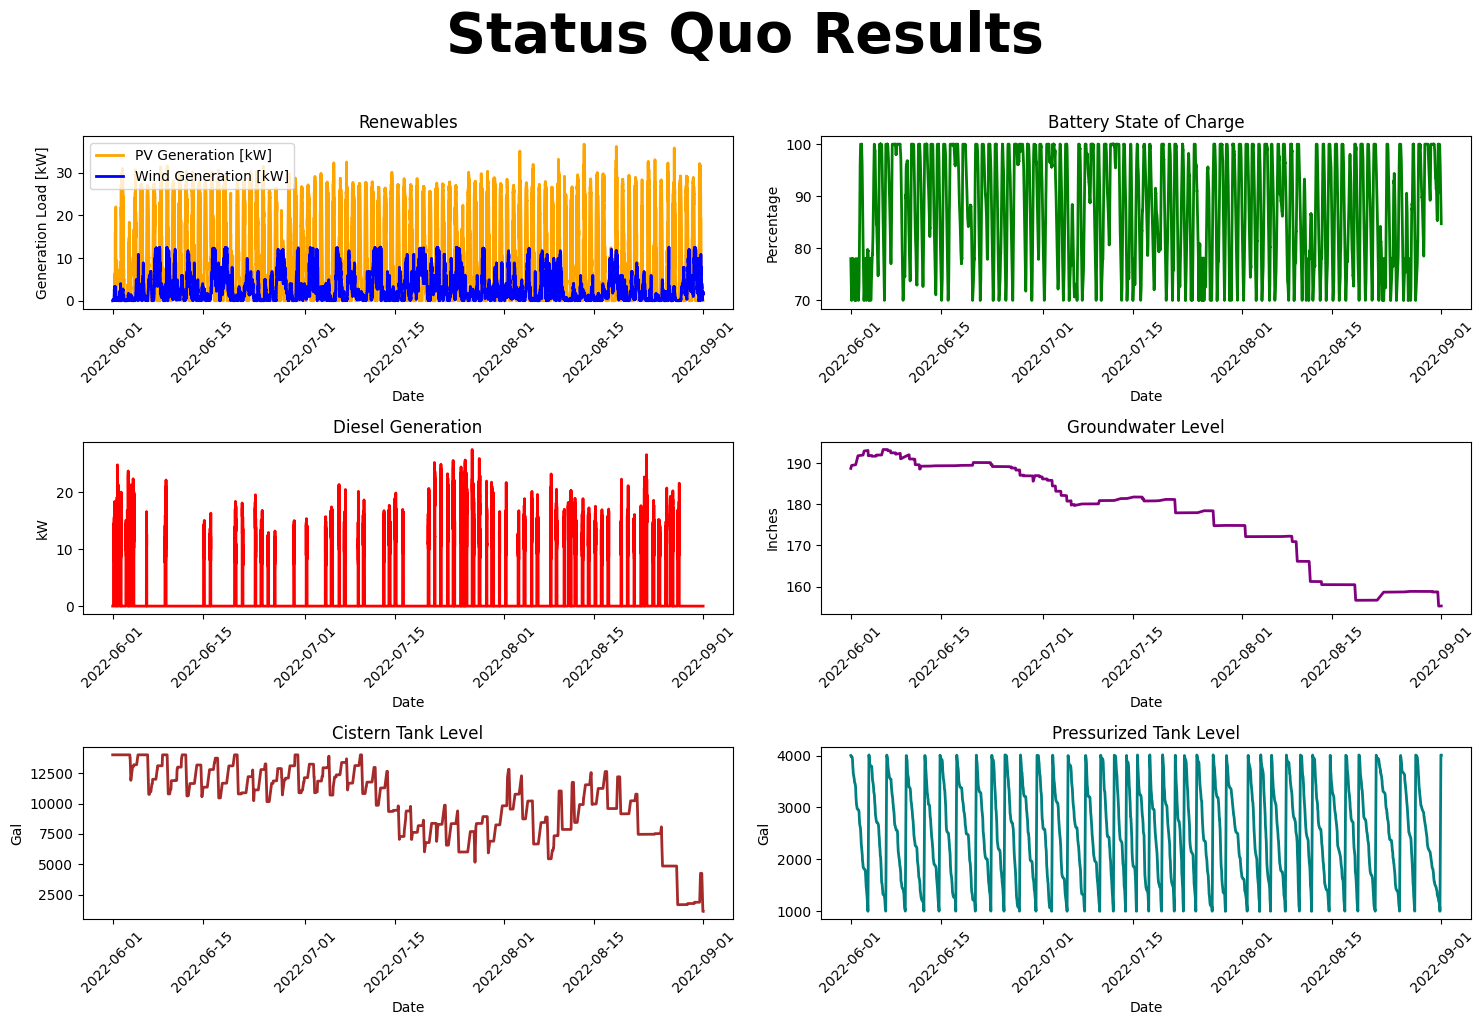

In [18]:
# Set the figure size and layout
fig, axs = plt.subplots(3, 2, figsize=(15, 10))  # 3 rows, 2 columns

# Main title for the entire figure
fig.suptitle("Status Quo Results", fontsize=40, fontweight='bold', y=1.02)

# 1. Renewables generation plot
axs[0, 0].plot(Results_SQ['Date'], Results_SQ['PV_Gen_kW'], label='PV Generation [kW]', color='orange', linewidth=2)
axs[0, 0].plot(Results_SQ['Date'], Results_SQ['Wind_Gen_kW'], label='Wind Generation [kW]', color='blue', linewidth=2)
axs[0, 0].set_title('Renewables')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Generation Load [kW]')
axs[0, 0].legend()
axs[0, 0].tick_params(axis='x', rotation=45)

# 2. Battery State of Charge plot
axs[0, 1].plot(Results_SQ['Date'], Results_SQ['SOC_c'], label='SOC', color='green', linewidth=2)
axs[0, 1].set_title('Battery State of Charge')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Percentage')
axs[0, 1].tick_params(axis='x', rotation=45)

# 3. Diesel generation plot
axs[1, 0].plot(Results_SQ['Date'], Results_SQ['Diesel_Gen_kW'], color='red', linewidth=2)
axs[1, 0].set_title('Diesel Generation')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('kW')
axs[1, 0].tick_params(axis='x', rotation=45)

# 4. Groundwater level plot
axs[1, 1].plot(Results_SQ['Date'], Results_SQ['Ground_Water_Depth'], color='purple', linewidth=2)
axs[1, 1].set_title('Groundwater Level')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Inches')
axs[1, 1].tick_params(axis='x', rotation=45)

# 5. Cistern Tank Level plot
axs[2, 0].plot(Results_SQ['Date'], Results_SQ['Cistern_Tank'], color='brown', linewidth=2)
axs[2, 0].set_title('Cistern Tank Level')
axs[2, 0].set_xlabel('Date')
axs[2, 0].set_ylabel('Gal')
axs[2, 0].tick_params(axis='x', rotation=45)

# 6. Pressurized Tank Level plot
axs[2, 1].plot(Results_SQ['Date'], Results_SQ['Pressure_Tank'], color='teal', linewidth=2)
axs[2, 1].set_title('Pressurized Tank Level')
axs[2, 1].set_xlabel('Date')
axs[2, 1].set_ylabel('Gal')
axs[2, 1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Run the Simulation (Heuristic Policy)

In [19]:
print("__Heuristic Policy__")
Results_HU = SML(T, RO_switch_v, Well_pump_switch_v,    WDemand_v, EDemand_v, GHI_W_m2_v, Ambient_temp_v, Wind_spd_IOSN3_v, R_v, Heuristic = True, Power_Table=Power_Table, Cistern_pump_switch = Cistern_pump_switch_init, Cistern_Tank = Cistern_Tank_init, Pressure_Tank = Pressure_Tank_init, Battery_SOC = Battery_SOC_init, Gen_switch = Gen_switch_init, H_Well = H_Well_init, Battery_total_cap_kWh=Battery_total_cap_kWh, Cistern_Max = Cistern_Max, Cistern_Rate=Cistern_Rate, RO_Rate=RO_Rate, Well_Rate=Well_Rate, RO_power = RO_power, Well_pump_power = Well_pump_power)


__Heuristic Policy__


Dynamic Simulation - SML Water Energy System: 100%|██████████| 132480/132480 [00:22<00:00, 5787.57Steps/s]


# Heuristic Policy Graphs:

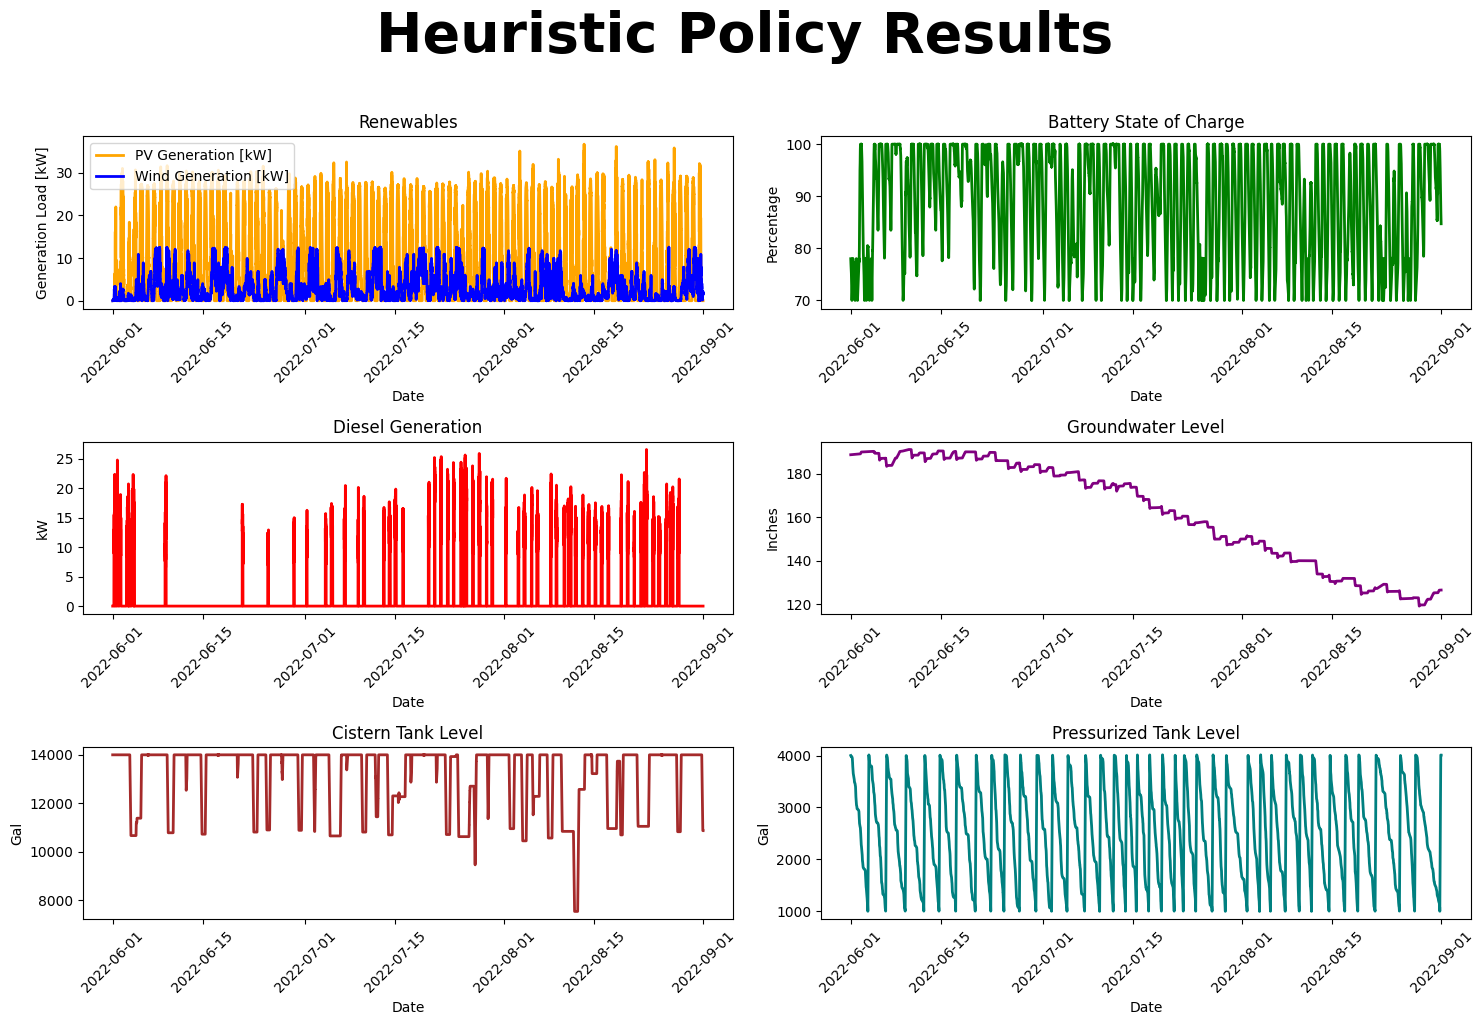

In [20]:
# Set the figure size and layout
fig, axs = plt.subplots(3, 2, figsize=(15, 10))  # 3 rows, 2 columns

# Main title for the entire figure
fig.suptitle("Heuristic Policy Results", fontsize=40, fontweight='bold', y=1.02)

# 1. Renewables generation plot
axs[0, 0].plot(Results_HU['Date'], Results_HU['PV_Gen_kW'], label='PV Generation [kW]', color='orange', linewidth=2)
axs[0, 0].plot(Results_HU['Date'], Results_HU['Wind_Gen_kW'], label='Wind Generation [kW]', color='blue', linewidth=2)
axs[0, 0].set_title('Renewables')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Generation Load [kW]')
axs[0, 0].legend()
axs[0, 0].tick_params(axis='x', rotation=45)

# 2. Battery State of Charge plot
axs[0, 1].plot(Results_HU['Date'], Results_HU['SOC_c'], label='SOC', color='green', linewidth=2)
axs[0, 1].set_title('Battery State of Charge')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Percentage')
axs[0, 1].tick_params(axis='x', rotation=45)

# 3. Diesel generation plot
axs[1, 0].plot(Results_HU['Date'], Results_HU['Diesel_Gen_kW'], color='red', linewidth=2)
axs[1, 0].set_title('Diesel Generation')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('kW')
axs[1, 0].tick_params(axis='x', rotation=45)

# 4. Groundwater level plot
axs[1, 1].plot(Results_HU['Date'], Results_HU['Ground_Water_Depth'], color='purple', linewidth=2)
axs[1, 1].set_title('Groundwater Level')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Inches')
axs[1, 1].tick_params(axis='x', rotation=45)

# 5. Cistern Tank Level plot
axs[2, 0].plot(Results_HU['Date'], Results_HU['Cistern_Tank'], color='brown', linewidth=2)
axs[2, 0].set_title('Cistern Tank Level')
axs[2, 0].set_xlabel('Date')
axs[2, 0].set_ylabel('Gal')
axs[2, 0].tick_params(axis='x', rotation=45)

# 6. Pressurized Tank Level plot
axs[2, 1].plot(Results_HU['Date'], Results_HU['Pressure_Tank'], color='teal', linewidth=2)
axs[2, 1].set_title('Pressurized Tank Level')
axs[2, 1].set_xlabel('Date')
axs[2, 1].set_ylabel('Gal')
axs[2, 1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Reinforcement Learning:
***
***


## 1. Reward and Transition Function

In [21]:
###############################################################################
# Model (Reward and Transition Function):
###############################################################################
# In Optimal Control Sequence the model should be deterministic for exogenous states as the weather condition reveals in real time.
def Model(Action, State, Control_Seq = False, Decision_Resolution = Decision_Resolution, T=T, Data=Data22,  Battery_total_cap_kWh=Battery_total_cap_kWh, Power_Table=Power_Table ,c_= c_, s_= s_, r_= r_, Lowest_H_Well=Lowest_H_Well, Highest_H_Well=Highest_H_Well, Cistern_tank_size=Cistern_Max, Cistern_pump_flow_rate=Cistern_Rate , RO_Rate=RO_Rate, Well_Rate = Well_Rate, RO_power = RO_power, Well_pump_power = Well_pump_power):
    
    t, Gen_switch, Cistern_pump_switch, Battery_SOC, Pressure_Tank, Cistern_Tank, H_Well,    WDemand, EDemand, GHI_W_m2, Ambient_temp, Wind_spd_IOSN3, R = State
    RO_switch, Well_pump_switch = Action
    
    Battery_total_cap_kWm = Battery_total_cap_kWh*60
    DC_BUS = Battery_SOC*Battery_total_cap_kWm/100
    
    r=0
    
    End = min(t+Decision_Resolution, T)
    for s in range(t, End):
        
        ## Endogenous States Update
        #Renewable generation
        PV_gen = PV_Gen(s, GHI_W_m2, Ambient_temp, Module_eff=0.155)
        Wind_gen = Wind_Gen(Wind_spd_IOSN3, Power_Table)
        
        #Total Demand
        RO_water_flow = RO(RO_switch, RO_desalination_rate=RO_Rate)
        Well_water_flow = Well(Well_pump_switch, H_Well, Lowest_H_Well=Lowest_H_Well , Well_rate = Well_Rate)

        Chlorine_RO, Chlorine_Well, Ch_RO_E_Sig, Ch_Well_E_Sig = Treat(RO_water_flow, Well_water_flow, Chlorine_rate_RO=2, Chlorine_rate_well=2)

        RO_water_flow += Chlorine_RO
        Well_water_flow += Chlorine_Well
        
        Cistern_pump_switch, Pressure_Tank, Water_flow_to_pressure_tank, Water_shortage = PTank(Pressure_Tank, Cistern_Tank, WDemand, Cistern_pump_switch, Cistern_pump_flow_rate=Cistern_pump_flow_rate, Pressure_tank_withdraw_size=5000, P_tank_up = 0.8, P_tank_low = 0.2, Water_shortage=0)
        Cistern_Tank, Excess_water = Cistern(Cistern_Tank, Well_water_flow, RO_water_flow, Water_flow_to_pressure_tank, Cistern_tank_size=Cistern_tank_size)
        Total_EDemand = E_Demand(RO_switch, Well_pump_switch, Water_flow_to_pressure_tank,  EDemand, RO_power = RO_power, Well_pump_power = Well_pump_power, Seawater_intake_power = 1050, Cistern_pump_power = 1050, RO_treat_power = 1, Well_treat_power = 1)
          
        #Watershed model
        H_Well = GroundWater(H_Well, Excess_water, Well_water_flow, R, A=1097, Highest_H_Well=Highest_H_Well)
        
        #Gen Switch update
        Battery_SOC_p = DC_BUS*100/Battery_total_cap_kWm

        Diesel_electricity_generation, Gen_switch= Diesel_Gen(Gen_switch, DC_BUS, Total_EDemand, PV_gen, Wind_gen, Battery_total_cap_kWh=250 , Gen_upper_bound=0.78, Gen_lower_bound=0.70, Diesel_gen_cap=2*27)
        
        #SOC update
        DC_BUS, Battery_SOC_c, Excess_energy, Excess_energy_signal = BoSys(DC_BUS, PV_gen, Wind_gen, Diesel_electricity_generation, Total_EDemand,  Excess_gen_production=0.32, DCtoAC_eff=0.925, Battery_total_cap_kWh=250)
        
        
        ## Exogenous States Update
        if s+1<T and Control_Seq:
            ## Exogenous States Update
            WDemand = Data.loc[s+1, 'Demand tPlusDifference (gal)'].item()
            EDemand = Data.loc[s+1, 'Demand (W)'].item()
            GHI_W_m2 = Data.loc[s+1, 'GHI (W/m2)'].item()
            Ambient_temp = Data.loc[s+1, 'AirTemperature (degrees C)'].item()
            Wind_spd_IOSN3 = Data.loc[s+1, 'WindSpeedIOSN3 (m/s)'].item()
            R = Data.loc[s+1, 'Rain (in)'].item()
        
        #Reward
        Score_C, Diesel_Gen_C, Waste_C, Cistern_C, RO_C, Well_C, Treat_C, Battery_C = CostScore(RO_switch, Well_pump_switch, Gen_switch, Cistern_pump_switch, Diesel_electricity_generation, Excess_energy, Battery_SOC, Battery_SOC_p, f_=f_, P_Diesel=P_Diesel, Dep_SeaPump_m=Dep_SeaPump_m ,Dep_CisPump_m=Dep_CisPump_m ,Dep_WllPump_m=Dep_WllPump_m ,Dep_Gen_m=Dep_Gen_m , Dep_RO_m=Dep_RO_m ,P_Batt=P_Batt, P_CL=P_CL, P_RO_Filter=P_RO_Filter,Max_Cost=Max_Cost, RO_Rate=RO_Rate,Well_Rate=Well_Rate )
        Score_S, Diesel_Gen_CO2, Waste_CO2, Cistern_CO2, RO_CO2, Well_CO2, Treat_CO2, Battery_CO2 = SusScore(RO_switch, Well_pump_switch, Gen_switch, Cistern_pump_switch, Diesel_electricity_generation, Excess_energy, Battery_SOC, Battery_SOC_p, CF_Diesel_kWm=CF_Diesel_kWm, CF_SeaPump_m=CF_SeaPump_m, CF_CisPump_m=CF_CisPump_m, CF_WllPump_m=CF_WllPump_m, CF_Gen_m=CF_Gen_m, CF_RO_m=CF_RO_m, CF_Batt=CF_Batt, Max_CF=Max_CF, RO_Rate=RO_Rate,Well_Rate=Well_Rate)
        Score_R = ReliScore(H_Well, Highest_H_Well=Highest_H_Well, Lowest_H_Well=Lowest_H_Well)

        if Water_shortage > 0:
            Lambda1 = Water_shortage/WDemand # Penalty for not satisfying demand.
        else:
            Lambda1 = 0
            
        if H_Well>=Highest_H_Well and (RO_switch == 1 or Well_pump_switch == 1):
            Lambda2 = Excess_water/(RO_switch*RO_Rate + Well_pump_switch*Well_Rate) #Penalty for well over run
        else:
            Lambda2 = 0
            
        if Gen_switch == 1 and (RO_switch == 1 or Well_pump_switch == 1): # Penalty for running on diesel
            Lambda3 = 1
        else:
            Lambda3 = 0
        
        if (Battery_SOC_p > Battery_SOC_c) and Excess_energy_signal<1 and Gen_switch<1 and (RO_switch==1 or Well_pump_switch==1):
            Lambda4 = (1-(Battery_SOC_c-70)/100)  #Penalty for faster discharge the battery (toward diesel consumption)
        elif (Battery_SOC_p < Battery_SOC_c) and Excess_energy_signal<1 and Gen_switch<1 and (RO_switch==1 or Well_pump_switch==1):
            Lambda4 = (-(Battery_SOC_c-70)/100)  #Incentive to use excess renewable
        else:
            Lambda4 = 0

        #Panalize for running on energy discharge!
        Lambda = Lambda1+Lambda2+Lambda3+Lambda4
        
        r = (c_ * Score_C) + (s_ * Score_S) + (r_ * Score_R) - Lambda
        
        # Now update the soc
        Battery_SOC = Battery_SOC_c.item()
        
    r /= Decision_Resolution
    
    State_Next = (s+1, Gen_switch, Cistern_pump_switch, Battery_SOC, Pressure_Tank, Cistern_Tank, H_Well,    WDemand, EDemand, GHI_W_m2, Ambient_temp, Wind_spd_IOSN3, R)
        
    return r, State_Next

## 2. Stochasticity of Exogenous States

In [22]:
###############################################################################
#States prediction:
###############################################################################
#Function generates one list of exogenous states for time t (6 elements)
def Ex_S_Rand(t,window_size = 30): #Returns one sampled list of exogenous state features for step i
    ##GHI and Temp
    # Randomly pick a row and a column
    random_row_index = t  # time identification
    random_column = np.random.choice([1, 2, 3, 4, 5])  # Random column
    
    # Check if the selected cell is NA
    while pd.isna(His['GHI_Full'].iloc[random_row_index, random_column]) or pd.isna(His['Temp_Full'].iloc[random_row_index, random_column]):
        
        random_column = np.random.choice([1, 2, 3, 4, 5]) # Pick another row index
    
    GHI=His['GHI_Full'].iloc[random_row_index, random_column]
    Temp=His['Temp_Full'].iloc[random_row_index, random_column]
    
    ##Water Demand
    original_list = Data22.loc[:, 'Demand tPlusDifference (gal)']

    # Calculate the start and end index for the window
    if random_row_index < window_size+1:
        start_index = 0
        end_index = random_row_index + window_size
    else:
        start_index = random_row_index - window_size
        end_index = random_row_index + window_size
        if end_index > len(original_list):
            end_index = len(original_list)
    
    # Extract the window of values
    window_values = original_list[start_index:end_index]
    
    # Calculate the mean and standard deviation for the window
    window_mean = np.mean(window_values)
    window_std_dev = np.std(window_values)
    
    #Assign the random value
    WD = np.random.normal(window_mean, window_std_dev)
    if WD<=0:
        WD=0
        
    ##Energy Demand
    original_list = Data22.loc[:, 'Demand (W)']


    # Calculate the start and end index for the window
    if random_row_index < window_size+1:
        start_index = 0
        end_index = random_row_index + window_size
    else:
        start_index = random_row_index - window_size
        end_index = random_row_index + window_size
        if end_index > len(original_list):
            end_index = len(original_list)

    # Extract the window of values
    window_values = original_list[start_index:end_index]

    # Calculate the mean and standard deviation for the window
    window_mean = np.mean(window_values)
    window_std_dev = np.std(window_values)

    #Assign the random value
    ED = (np.random.normal(window_mean, window_std_dev))
    if ED<=0:
        ED=0
    
    ##Wind speed and Precipitation
    # Randomly pick a row and a column
    random_row_index = t
    random_column = np.random.choice([1, 2, 3, 4, 5])  # Random column

    # Check if the selected cell is NA
    while pd.isna(His['Wind_Full'].iloc[random_row_index, random_column]):
        
        random_column = np.random.choice([1, 2, 3, 4, 5]) # Pick another row index

    #Assign random values
    Wind = (His['Wind_Full'].iloc[random_row_index, random_column])
    R = (Data22.loc[np.random.randint(0, len(Data22)),'Rain (in)'])

    return [WD, ED, GHI.item(), Temp.item(), Wind.item(), R.item()]

#Function returns 6 lists of n sampled exogenous states at time t
def Ex_S_Rand_List_t(n, t):
    # Endogenous states
    # Exogenous states
    WDemand = []
    EDemand = []
    GHI_W_m2 = []
    Ambient_temp = []
    Wind_spd_IOSN3 = []
    R = []

    for _ in range(n):
        
        a=Ex_S_Rand(t)
        
        WDemand.append(a[0])
        EDemand.append(a[1])
        GHI_W_m2.append(a[2])
        Ambient_temp.append(a[3])
        Wind_spd_IOSN3.append(a[4])
        R.append(a[5])
    
    return [WDemand, EDemand, GHI_W_m2, Ambient_temp, Wind_spd_IOSN3, R]

#Function returns 6 lists of n sampled endogenous states (not time dependent_uniformly)
def End_S_Rand_List(n): # returns n samples of endogenous state features
    # Endogenous states
    Gen_switch = random.choices([0, 1], k=n)
    Cistern_pump_switch = random.choices([0, 1], k=n)
    Battery_SOC = [round(random.uniform(69, 100.0001), 2) for _ in range(n)]
    Pressure_Tank = [round(random.uniform(0, 4000.0001), 2) for _ in range(n)]
    Cistern_Tank = [round(random.uniform(0, 20000+0.0001), 2) for _ in range(n)]
    H_Well = [round(random.uniform(Lowest_H_Well, Highest_H_Well), 2) for _ in range(n)]
    
    return [Gen_switch, Cistern_pump_switch, Battery_SOC, Pressure_Tank, Cistern_Tank, H_Well]

###############################################################################
#Test transition and reward function:
###############################################################################

State = [0, 1, 1, 86, 3500, 10000, 150, 0.5, 5670, 15, 20, 3.5, 0.00001]
Action = [0, 1]

r, State_Next = Model(Action, State)

print(f'Reward is equal to {r} and next state is {State_Next}')

Reward is equal to 0.0293152103438733 and next state is (5, 0, 1, 85.83373761870003, 3570.0, 10000.000132783489, 149.89402413541526, 0.5, 5670, 15, 20, 3.5, 1e-05)


## 3. Fitted Value Iteration (FVI)

### 3.1 Q functions:

In [23]:
def Q(State, Model_NN, Action_Space = [[1,1], [1,0], [0,1], [0,0]], d_r=d_r, Control_Seq = False, Decision_Resolution = Decision_Resolution, T=T, Data=Data22,  Battery_total_cap_kWh=Battery_total_cap_kWh, Power_Table=Power_Table ,c_= c_, s_= s_, r_= r_, Lowest_H_Well=Lowest_H_Well, Highest_H_Well=Highest_H_Well, Cistern_Max=Cistern_Max, Cistern_Rate=Cistern_Rate , RO_Rate=RO_Rate, Well_Rate = Well_Rate, RO_power = RO_power, Well_pump_power = Well_pump_power):

    v=0
    a=[1,1]
    _, s = Model(a, State, Control_Seq = Control_Seq, Decision_Resolution = Decision_Resolution, T=T, Data=Data,  Battery_total_cap_kWh=Battery_total_cap_kWh, Power_Table=Power_Table ,c_= c_, s_= s_, r_= r_, Lowest_H_Well=Lowest_H_Well, Highest_H_Well=Highest_H_Well, Cistern_tank_size=Cistern_Max, Cistern_pump_flow_rate=Cistern_Rate , RO_Rate=RO_Rate, Well_Rate = Well_Rate, RO_power = RO_power, Well_pump_power = Well_pump_power)
    for Action in Action_Space:
    
        r, State_N = Model(Action, State, Control_Seq = Control_Seq, Decision_Resolution = Decision_Resolution, T=T, Data=Data,  Battery_total_cap_kWh=Battery_total_cap_kWh, Power_Table=Power_Table ,c_= c_, s_= s_, r_= r_, Lowest_H_Well=Lowest_H_Well, Highest_H_Well=Highest_H_Well, Cistern_tank_size=Cistern_Max, Cistern_pump_flow_rate=Cistern_Rate , RO_Rate=RO_Rate, Well_Rate = Well_Rate, RO_power = RO_power, Well_pump_power = Well_pump_power)
        if State[0] == T-Decision_Resolution: # In terminal state the value equals to reward at that time.
            if r.item() > v :
                v = r.item()
                a = Action
                s = State_N
        else:
            if r.item()+b.NN_pred(Model_NN, State_N)*d_r > v :
                v = r.item()+b.NN_pred(Model_NN, State_N)*d_r
                a = Action
                s = State_N
    
    Max_r = v
    Action_of_Max_r = a
    Next_State_of_Max_r = s
        
    return Max_r, Next_State_of_Max_r, Action_of_Max_r

### 3.2 FVI algorithm:

In [24]:
def FVI(T=T, d_r=d_r, n_FVI=n_FVI, Decision_Resolution=Decision_Resolution, c_=c_ ,s_=s_ , r_=r_,num_epochs=num_epochs,
                                           batch_size=batch_size, L1=L1, L2=L2, L3=L3, Cistern_Max=Cistern_Max, Cistern_Rate=Cistern_Rate , RO_Rate=RO_Rate, Well_Rate = Well_Rate, RO_power = RO_power, Well_pump_power = Well_pump_power):
    ## Starts backward
    # Terminal decision:
    t=T-Decision_Resolution
    
    all_transposed_sampled_states = []
    all_values = []

    # Generate n states
    S_ex = Ex_S_Rand_List_t(n_FVI, t)
    S_en = End_S_Rand_List(n_FVI)
    Sampled_State = [[t]*n_FVI]+S_en+S_ex
    
    Transposed_Sampled_State = list(zip(*Sampled_State))
    
    Value = []
    Model_NN = 0
    for s in enumerate(Transposed_Sampled_State):
        #print(s)
        Max_r, Next_State_of_Max_r, Action_of_Max_r = Q(s[1], Model_NN, Action_Space = [[0,0], [0,1], [1,0], [1,1]], d_r=d_r, Control_Seq = False, Decision_Resolution = Decision_Resolution, T=T, Data=Data22,  Battery_total_cap_kWh=Battery_total_cap_kWh, Power_Table=Power_Table ,c_= c_, s_= s_, r_= r_, Lowest_H_Well=Lowest_H_Well, Highest_H_Well=Highest_H_Well, Cistern_Max=Cistern_Max, Cistern_Rate=Cistern_Rate , RO_Rate=RO_Rate, Well_Rate = Well_Rate, RO_power = RO_power, Well_pump_power = Well_pump_power)
        Value.append(Max_r)
    
    all_transposed_sampled_states.extend(Transposed_Sampled_State)
    all_values.extend(Value)
    # Train the model
    Model_NN, losses, test_loss = b.RL_NN_3L(Transposed_Sampled_State, Value, num_epochs=num_epochs,
                                           batch_size=batch_size, L1=L1, L2=L2, L3=L3)
    test_losses.append(test_loss)
    
    # Time step T-30 to 0:
    for d in tqdm(range(2, int(T/Decision_Resolution)+1), desc="Training Process: ", unit="steps"):
        t=T-d*Decision_Resolution
        # Generate n states
        S_ex = Ex_S_Rand_List_t(n_FVI, t)
        S_en = End_S_Rand_List(n_FVI)
        Sampled_State = [[t]*n_FVI]+S_en+S_ex
        
        Transposed_Sampled_State = list(zip(*Sampled_State))
        
        Value = []
        for s in enumerate(Transposed_Sampled_State):
            
            Max_r, Next_State_of_Max_r, Action_of_Max_r = Q(s[1], Model_NN, Action_Space = [[0,0], [0,1], [1,0], [1,1]], d_r=d_r, Control_Seq = False, Decision_Resolution = Decision_Resolution, T=T, Data=Data22,  Battery_total_cap_kWh=Battery_total_cap_kWh, Power_Table=Power_Table ,c_= c_, s_= s_, r_= r_, Lowest_H_Well=Lowest_H_Well, Highest_H_Well=Highest_H_Well, Cistern_Max=Cistern_Max, Cistern_Rate=Cistern_Rate , RO_Rate=RO_Rate, Well_Rate = Well_Rate, RO_power = RO_power, Well_pump_power = Well_pump_power)
            Value.append(Max_r)

        all_transposed_sampled_states.extend(Transposed_Sampled_State)
        all_values.extend(Value)
        # Fine-tune the model with the new random data
        Model_NN, losses, test_loss = b.fine_tune_existing_model(Model_NN, Transposed_Sampled_State, Value, batch_size=batch_size, fine_tune_epochs=num_epochs)
        
        test_losses.append(test_loss)
        
    
    return Model_NN, test_losses #, all_transposed_sampled_states, all_values

## 4. Optimal Control Sequence

In [25]:
def OptContSeq(Model_NN, State_initial = State_initial, Data=Data22, d_r = d_r, Decision_Resolution=Decision_Resolution, c_=c_ ,s_=s_ , r_=r_, Cistern_Max=Cistern_Max, Cistern_Rate=Cistern_Rate , RO_Rate=RO_Rate, Well_Rate = Well_Rate, RO_power = RO_power, Well_pump_power = Well_pump_power):
    RO_switch_ = []
    Well_pump_switch_ = []
    State = State_initial
    
    for time in tqdm(range(0,T,Decision_Resolution), desc="Control Sequence: ", unit="steps"):
        #Constraints
        if (State[1]  == 1) and State[5]  >= Cistern_Max:
            Action_Space = [[0,0]] #Avoids running on diesel
        elif (State[1]  == 1) and State[5]  <= 0.1*Cistern_Max:
            Action_Space = [[0,1]] #Avoids water outage but running the well
        elif (State[1]  == 0) and State[5]  >= Cistern_Max:
            Action_Space = [[0,0], [1,0]] #Avoids running the well pump when recharging the well
        elif (State[1]  == 0) and State[5]  <= 0.1*Cistern_Max:
            Action_Space = [[0,1], [1,1]] #Avoids water outage but running the well
        else:
            Action_Space = [[0,0], [0,1], [1,0], [1,1]]
            
            
        _, State_N, Action_of_Max_r = Q(State, Model_NN, Action_Space = Action_Space, d_r=d_r, Control_Seq = True, Decision_Resolution = Decision_Resolution, T=T, Data=Data,  Battery_total_cap_kWh=Battery_total_cap_kWh, Power_Table=Power_Table ,c_= c_, s_= s_, r_= r_, Lowest_H_Well=Lowest_H_Well, Highest_H_Well=Highest_H_Well, Cistern_Max=Cistern_Max, Cistern_Rate=Cistern_Rate , RO_Rate=RO_Rate, Well_Rate = Well_Rate, RO_power = RO_power, Well_pump_power = Well_pump_power)

        State = State_N
        
        
        for t_ in range(0,Decision_Resolution):
            
            RO_switch_.append(Action_of_Max_r[0])
            Well_pump_switch_.append(Action_of_Max_r[1])
        
        
    return RO_switch_, Well_pump_switch_

## 5. Run the Training and find the Optimal Control Sequence

In [26]:
#Agent Training
Model_NN, test_losses = FVI(T=T, d_r=d_r, n_FVI=n_FVI, Decision_Resolution=Decision_Resolution, c_=c_ ,s_=s_ , r_=r_,num_epochs=num_epochs,
                                           batch_size=batch_size, L1=L1, L2=L2, L3=L3, Cistern_Max=Cistern_Max, Cistern_Rate=Cistern_Rate , RO_Rate=RO_Rate, Well_Rate = Well_Rate, RO_power = RO_power, Well_pump_power = Well_pump_power)


Training Process: 100%|██████████| 26495/26495 [5:19:48<00:00,  1.38steps/s]   


In [27]:
#Find Optimal Control Sequence:
RO_switch_, Well_pump_switch_ = OptContSeq(Model_NN, State_initial = State_initial, Data=Data22, d_r = d_r, 
                                           Decision_Resolution=Decision_Resolution, c_=c_ ,s_=s_ , r_=r_, Cistern_Max=Cistern_Max, Cistern_Rate=Cistern_Rate , RO_Rate=RO_Rate, Well_Rate = Well_Rate, RO_power = RO_power, Well_pump_power = Well_pump_power)


Control Sequence: 100%|██████████| 26496/26496 [01:47<00:00, 247.53steps/s]


# Run the Simulation for RL Solution

In [28]:
Results_RL = SML(T, RO_switch_, Well_pump_switch_,    WDemand_v, EDemand_v, GHI_W_m2_v, Ambient_temp_v, Wind_spd_IOSN3_v, R_v, Heuristic = False, Power_Table=Power_Table, Cistern_pump_switch = Cistern_pump_switch_init, Cistern_Tank = Cistern_Tank_init, Pressure_Tank = Pressure_Tank_init, Battery_SOC = Battery_SOC_init, Gen_switch = Gen_switch_init, H_Well = H_Well_init, Battery_total_cap_kWh=Battery_total_cap_kWh, Cistern_Max = Cistern_Max, Cistern_Rate=Cistern_Rate, RO_Rate=RO_Rate, Well_Rate=Well_Rate, RO_power = RO_power, Well_pump_power = Well_pump_power)


Dynamic Simulation - SML Water Energy System: 100%|██████████| 132480/132480 [00:17<00:00, 7528.18Steps/s]


# RL Solution Graphs

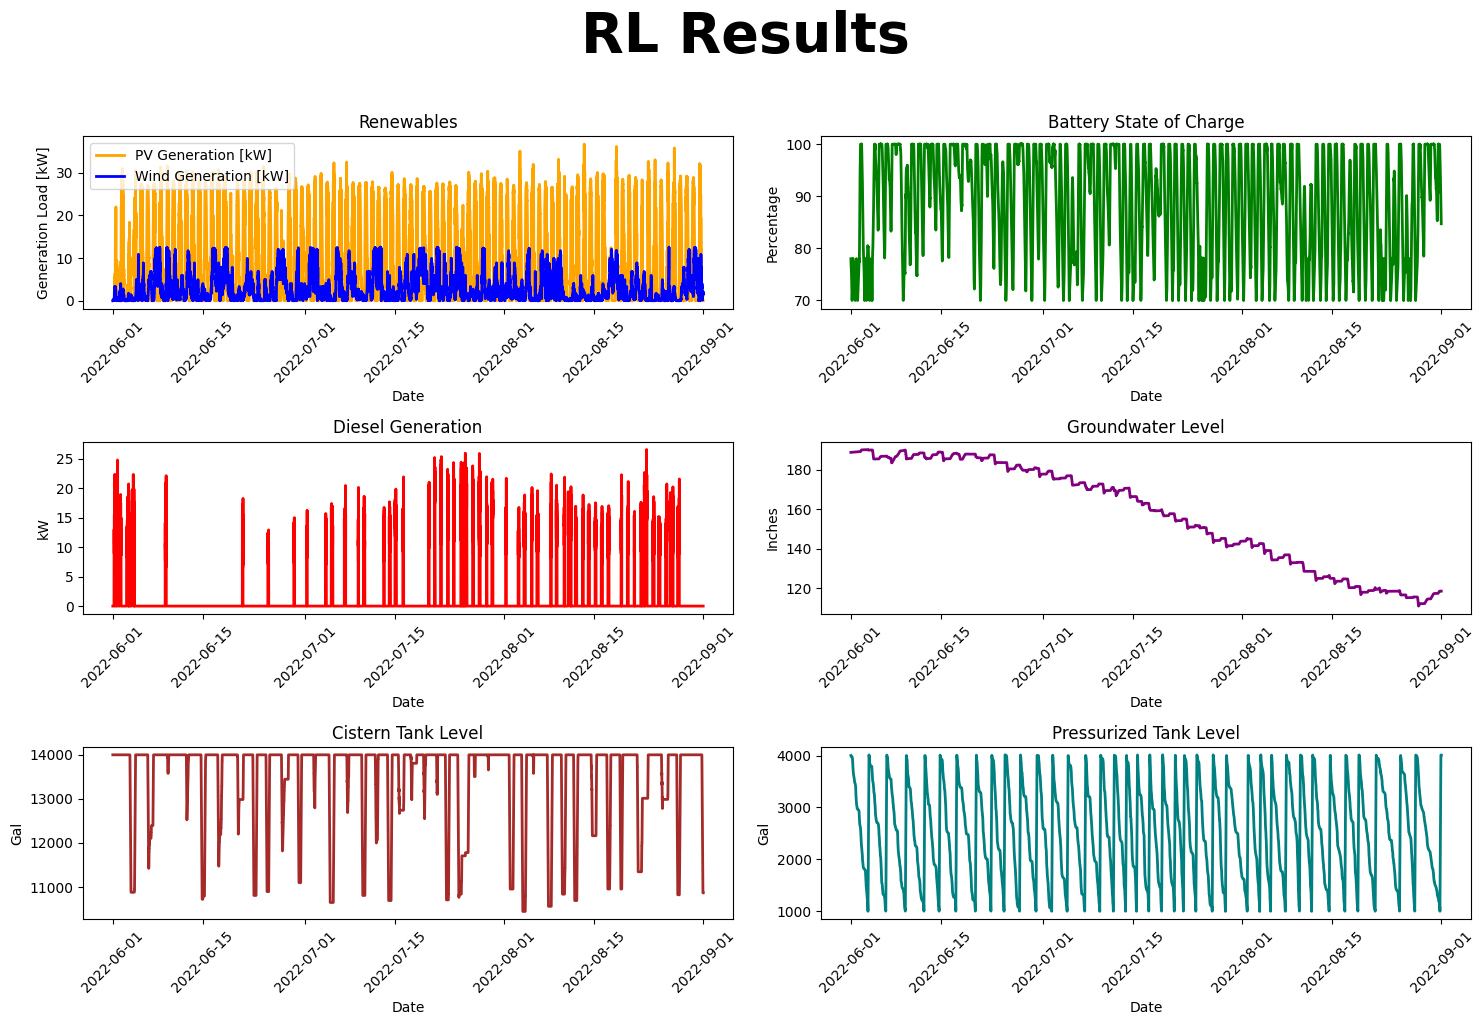

In [29]:
# Set the figure size and layout
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# Main title for the entire figure
fig.suptitle("RL Results", fontsize=40, fontweight='bold', y=1.02)

# 1. Renewables generation plot
axs[0, 0].plot(Results_RL['Date'], Results_RL['PV_Gen_kW'], label='PV Generation [kW]', color='orange', linewidth=2)
axs[0, 0].plot(Results_RL['Date'], Results_RL['Wind_Gen_kW'], label='Wind Generation [kW]', color='blue', linewidth=2)
axs[0, 0].set_title('Renewables')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Generation Load [kW]')
axs[0, 0].legend()
axs[0, 0].tick_params(axis='x', rotation=45)

# 2. Battery State of Charge plot
axs[0, 1].plot(Results_RL['Date'], Results_RL['SOC_c'], label='SOC', color='green', linewidth=2)
axs[0, 1].set_title('Battery State of Charge')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Percentage')
axs[0, 1].tick_params(axis='x', rotation=45)

# 3. Diesel generation plot
axs[1, 0].plot(Results_RL['Date'], Results_RL['Diesel_Gen_kW'], color='red', linewidth=2)
axs[1, 0].set_title('Diesel Generation')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('kW')
axs[1, 0].tick_params(axis='x', rotation=45)

# 4. Groundwater level plot
axs[1, 1].plot(Results_RL['Date'], Results_RL['Ground_Water_Depth'], color='purple', linewidth=2)
axs[1, 1].set_title('Groundwater Level')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Inches')
axs[1, 1].tick_params(axis='x', rotation=45)

# 5. Cistern Tank Level plot
axs[2, 0].plot(Results_RL['Date'], Results_RL['Cistern_Tank'], color='brown', linewidth=2)
axs[2, 0].set_title('Cistern Tank Level')
axs[2, 0].set_xlabel('Date')
axs[2, 0].set_ylabel('Gal')
axs[2, 0].tick_params(axis='x', rotation=45)

# 6. Pressurized Tank Level plot
axs[2, 1].plot(Results_RL['Date'], Results_RL['Pressure_Tank'], color='teal', linewidth=2)
axs[2, 1].set_title('Pressurized Tank Level')
axs[2, 1].set_xlabel('Date')
axs[2, 1].set_ylabel('Gal')
axs[2, 1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Comparison Graphs, Save Model and CSV Files
***

## 1. Set up results folder and save model results

In [30]:

Results_path = os.path.join(Py_file_directory , f"C_{c_}_S_{s_}_R_{r_}")

if os.path.exists(Results_path) and os.path.isdir(Results_path):
    print("Results folder exists. Home directory changed to Results")
else:
    # If the folder doesn't exist, create it and then change the current working directory to it
    os.makedirs(Results_path)
    print("Results folder is created. Home directory changed to Results")

os.chdir(Results_path)
base_directory = os.getcwd()



# Set Result Inner Directory
# Initialize the directory number
directory_number = 1

# Construct the directory path
directory_path = os.path.join(Results_path, str(directory_number))

# Check if the directory exists
while os.path.exists(directory_path):
    # Increment the directory number
    directory_number += 1
    # Construct the new directory path
    directory_path = os.path.join(Results_path, str(directory_number))

# Create the directory
os.makedirs(directory_path)
os.chdir(directory_path)

print(f" Results save in: {directory_path}")

Results folder is created. Home directory changed to Results
 Results save in: /Users/whisper/Library/CloudStorage/OneDrive-USNH/Roozbeh PhD research/Project 7 SML Water-Energy modeling/System Dynamics/SML Python SD Model/Sensitivity Analysis 1/C_0_S_1_R_0/1


In [31]:
#Save the NN model
torch.save(Model_NN.state_dict(), "Agent_NN.pth")

Results_HU.to_csv('Results_Heuristic.csv', index=False)
Results_SQ.to_csv('Results_StatusQuo.csv', index=False)
Results_RL.to_csv('Results_RL.csv', index=False)

## 2. Graphs comparing three models

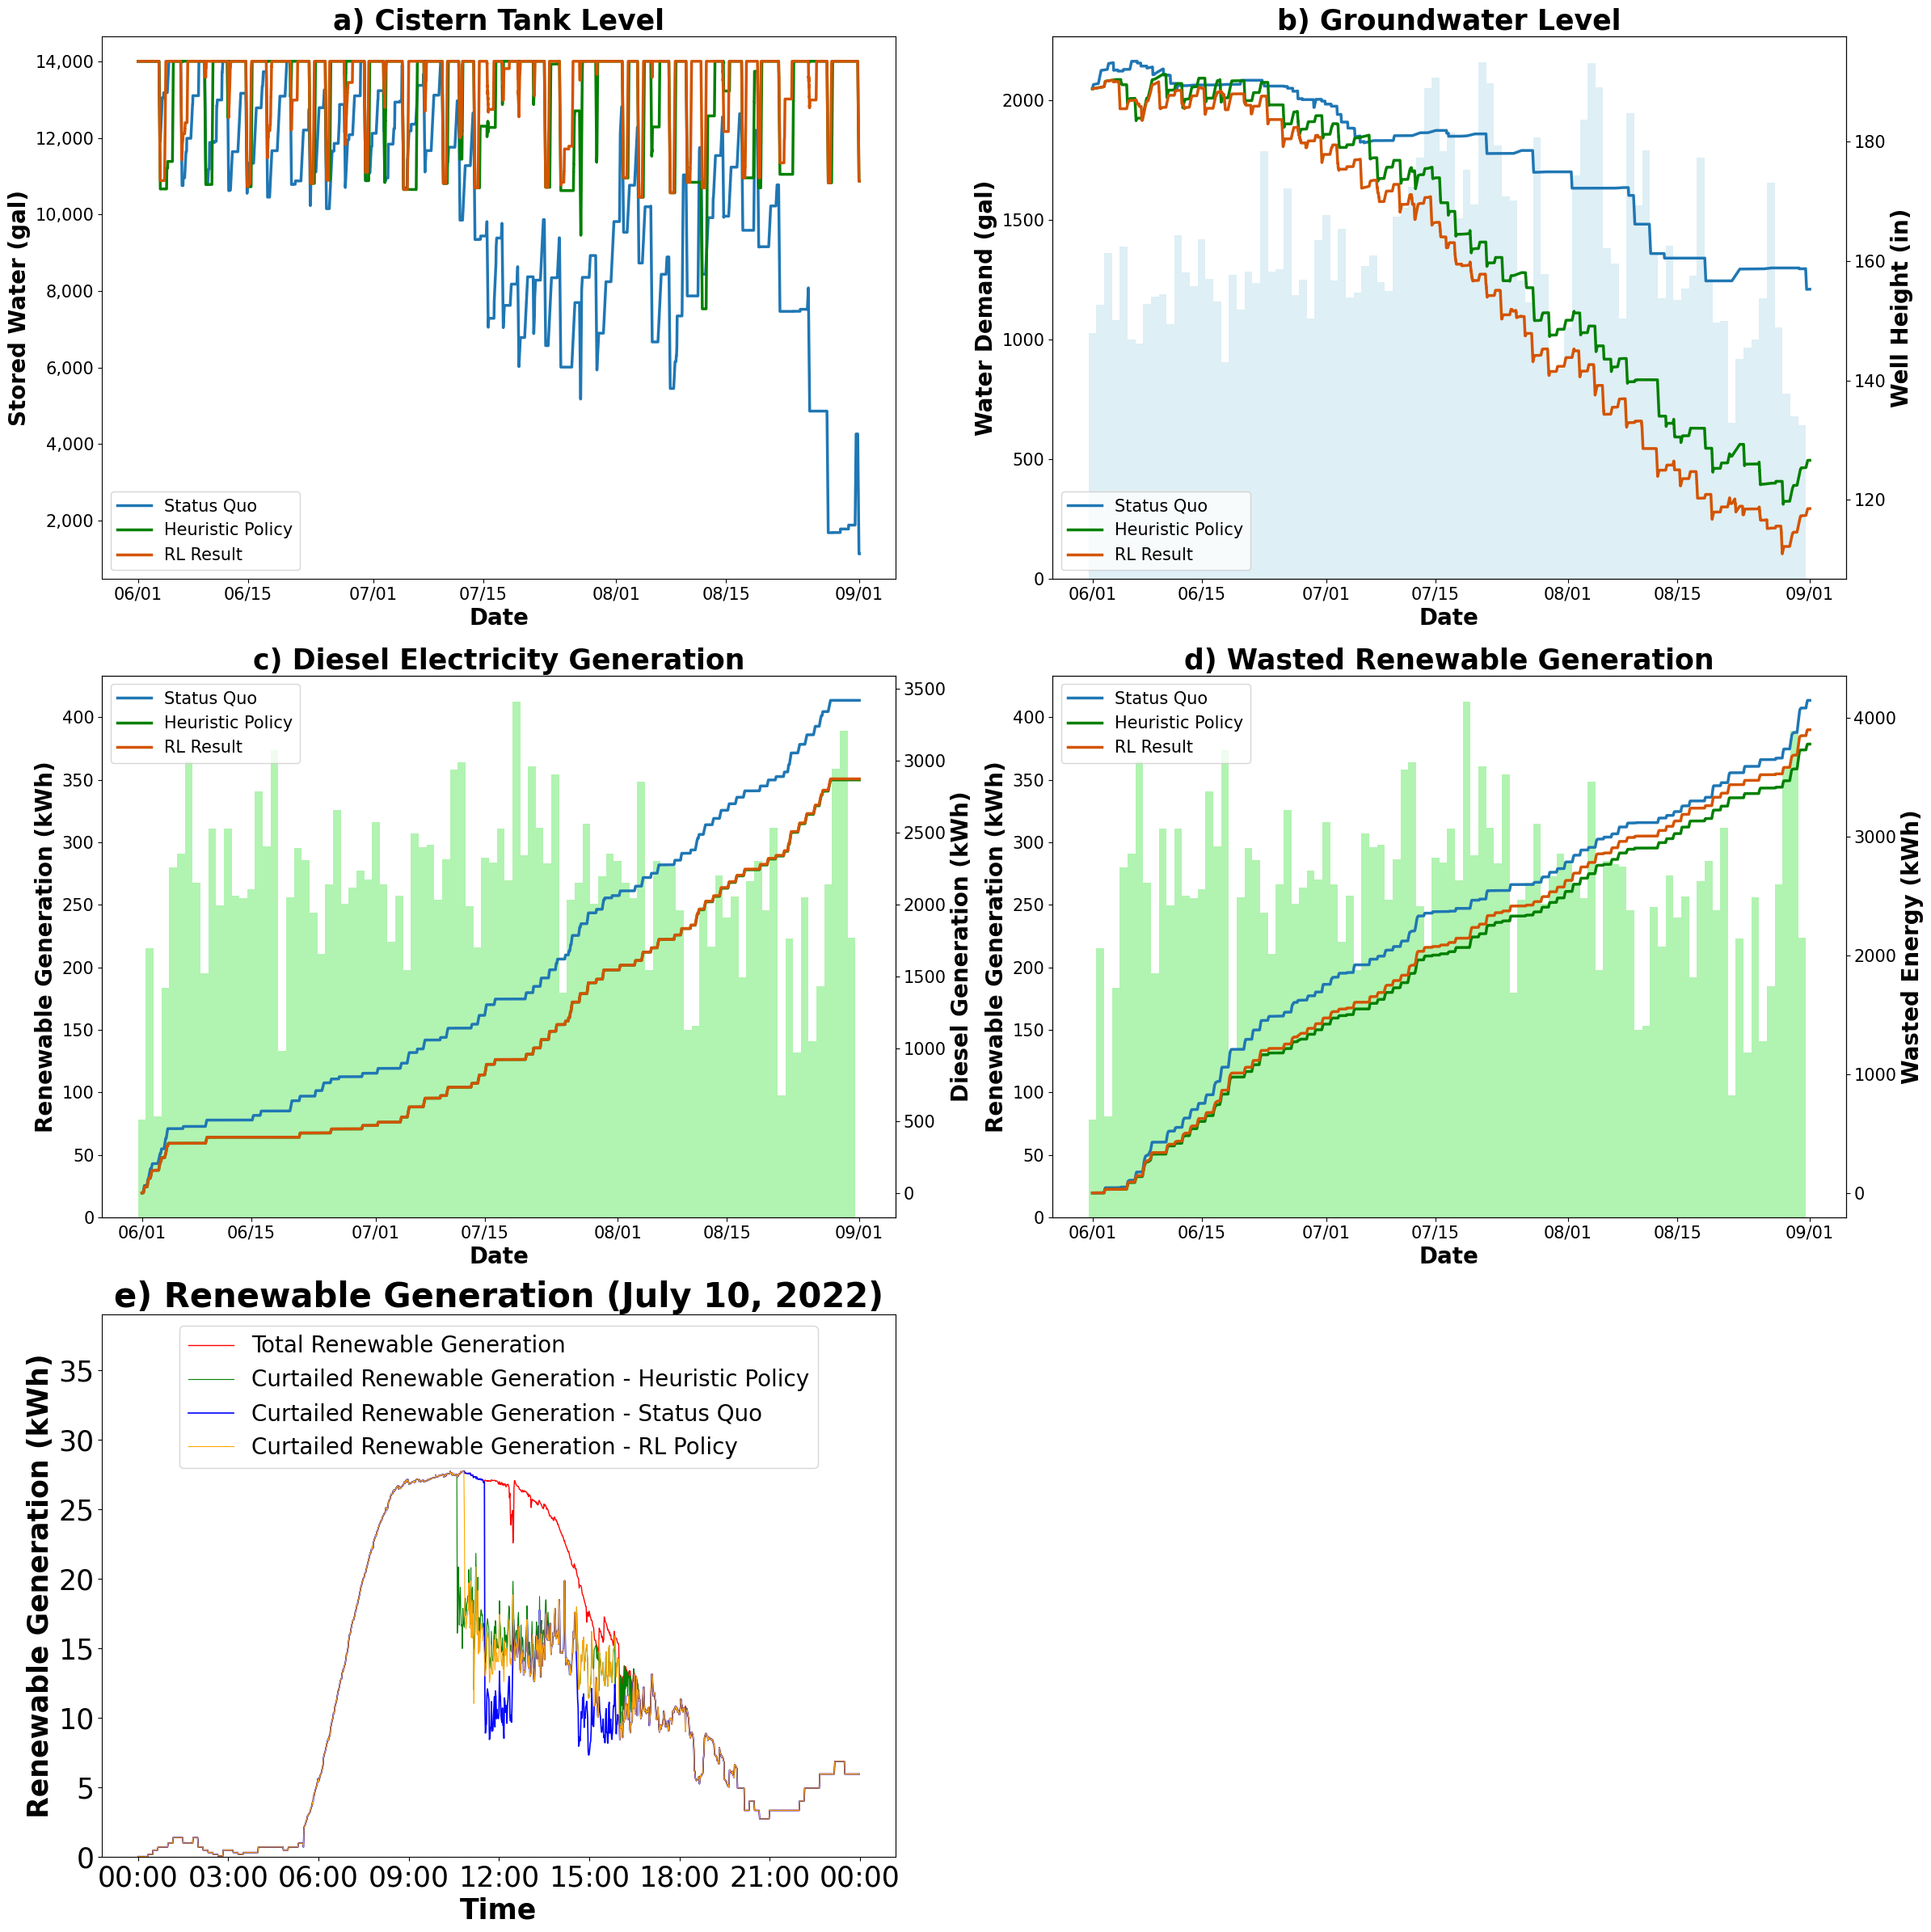

In [32]:
Water_Demand = WDemand_v.groupby(Data22.index // 1440).sum()
Ren_Gen = (Results_SQ['PV_Gen_kW'] + Results_SQ['Wind_Gen_kW']).groupby(Results_SQ.index // 1440).sum()/60

# Function to format y-ticks with commas
def format_yticks_comma(x, pos):
    return '{:,.0f}'.format(x)

# Create the figure and subplots (3 rows x 2 columns, but span the last row across both columns)
fig, axs = plt.subplots(3, 2, figsize=(24, 24))  # 5 plots arranged in 3x2

# Subplot a - Cistern Tank Level
axs[0, 0].plot(Results_SQ['Date'], Results_SQ['Cistern_Tank'], label='Status Quo', linewidth=2.5)
axs[0, 0].plot(Results_HU['Date'], Results_HU['Cistern_Tank'], label='Heuristic Policy', color='green', linewidth=2.5)
axs[0, 0].plot(Results_RL['Date'], Results_RL['Cistern_Tank'], label='RL Result', color='#d35400', linewidth=2.5)
axs[0, 0].set_xlabel('Date', fontweight='bold', fontsize=20)
axs[0, 0].set_ylabel('Stored Water (gal)', fontweight='bold', fontsize=20)
axs[0, 0].set_title('a) Cistern Tank Level', fontweight='bold', fontsize=25)
axs[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
axs[0, 0].tick_params(axis='x', labelsize=15)
axs[0, 0].tick_params(axis='y', labelsize=15)
axs[0, 0].yaxis.set_major_formatter(FuncFormatter(format_yticks_comma))
axs[0, 0].legend(fontsize=15)

# Subplot b - Groundwater Level with Water Demand (bar)
bars_b = axs[0, 1].bar(Results_SQ['Date'][::1440], Water_Demand, color='lightblue', width=1.0, alpha=0.4, label='Water Demand')
ax2_b = axs[0, 1].twinx()  # Secondary y-axis for the lines
ax2_b.plot(Results_SQ['Date'], Results_SQ['Ground_Water_Depth'], label='Status Quo', linewidth=2.5)
ax2_b.plot(Results_HU['Date'], Results_HU['Ground_Water_Depth'], label='Heuristic Policy', color='green', linewidth=2.5)
ax2_b.plot(Results_RL['Date'], Results_RL['Ground_Water_Depth'], label='RL Result', color='#d35400', linewidth=2.5)
axs[0, 1].set_xlabel('Date', fontweight='bold', fontsize=20)
axs[0, 1].set_ylabel('Water Demand (gal)', fontweight='bold', fontsize=20)
ax2_b.set_ylabel('Well Height (in)', fontweight='bold', fontsize=20)
axs[0, 1].set_title('b) Groundwater Level', fontweight='bold', fontsize=25)
axs[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
axs[0, 1].tick_params(axis='x', labelsize=15)
axs[0, 1].tick_params(axis='y', labelsize=15)
ax2_b.tick_params(axis='y', labelsize=15)
ax2_b.legend(loc='lower left', fontsize=15)

# Subplot c - Diesel Generation with Renewable Generation (bar)
bars_c = axs[1, 0].bar(Results_SQ['Date'][::1440], Ren_Gen, color='lightgreen', width=1.0, alpha=0.7, label='Renewable Generation (kWh)')
ax2_c = axs[1, 0].twinx()  # Secondary y-axis for the lines
ax2_c.plot(Results_SQ['Date'], np.cumsum(Results_SQ['Diesel_Gen_kW']) / 60, label='Status Quo', linewidth=2.5)
ax2_c.plot(Results_HU['Date'], np.cumsum(Results_HU['Diesel_Gen_kW']) / 60, label='Heuristic Policy', color='green', linewidth=2.5)
ax2_c.plot(Results_RL['Date'], np.cumsum(Results_RL['Diesel_Gen_kW']) / 60, label='RL Result', color='#d35400', linewidth=2.5)
axs[1, 0].set_xlabel('Date', fontweight='bold', fontsize=20)
axs[1, 0].set_ylabel('Renewable Generation (kWh)', fontweight='bold', fontsize=20)
ax2_c.set_ylabel('Diesel Generation (kWh)', fontweight='bold', fontsize=20)
axs[1, 0].set_title('c) Diesel Electricity Generation', fontweight='bold', fontsize=25)
axs[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
axs[1, 0].tick_params(axis='x', labelsize=15)
axs[1, 0].tick_params(axis='y', labelsize=15)
ax2_c.tick_params(axis='y', labelsize=15)
ax2_c.legend(loc='upper left', fontsize=15)

# Subplot d - Wasted Energy with Renewable Generation (bar)
bars_d = axs[1, 1].bar(Results_SQ['Date'][::1440], Ren_Gen, color='lightgreen', width=1.0, alpha=0.7, label='Renewable Generation (kWh)')
ax2_d = axs[1, 1].twinx()  # Secondary y-axis for the lines
ax2_d.plot(Results_SQ['Date'], np.cumsum(Results_SQ['Excess_E_kW']) / 60, label='Status Quo', linewidth=2.5)
ax2_d.plot(Results_HU['Date'], np.cumsum(Results_HU['Excess_E_kW']) / 60, label='Heuristic Policy', color='green', linewidth=2.5)
ax2_d.plot(Results_RL['Date'], np.cumsum(Results_RL['Excess_E_kW']) / 60, label='RL Result', color='#d35400', linewidth=2.5)
axs[1, 1].set_xlabel('Date', fontweight='bold', fontsize=20)
axs[1, 1].set_ylabel('Renewable Generation (kWh)', fontweight='bold', fontsize=20)
ax2_d.set_ylabel('Wasted Energy (kWh)', fontweight='bold', fontsize=20)
axs[1, 1].set_title('d) Wasted Renewable Generation', fontweight='bold', fontsize=25)
axs[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
axs[1, 1].tick_params(axis='x', labelsize=15)
axs[1, 1].tick_params(axis='y', labelsize=15)
ax2_d.tick_params(axis='y', labelsize=15)
ax2_d.legend(loc='upper left', fontsize=15)

# Subplot e - Wasted Renewable Energy Comparison for a Specific Day (spanning both columns)
d = 39
SQ_W = round(sum(Results_SQ['Excess_E_kW'][d*1440:(d+1)*1440])/60)
HU_W = round(sum(Results_HU['Excess_E_kW'][d*1440:(d+1)*1440])/60)
RL_W = round(sum(Results_RL['Excess_E_kW'][d*1440:(d+1)*1440])/60)

axs[2, 0].plot(Results_HU['Date'][d*1440:(d+1)*1440], 
                (Results_HU['PV_Gen_kW'] + Results_HU['Wind_Gen_kW'])[d*1440:(d+1)*1440], 
                label='Total Renewable Generation', color='red', linewidth=1)

axs[2, 0].plot(Results_HU['Date'][d*1440:(d+1)*1440], 
                ((Results_HU['PV_Gen_kW'] + Results_HU['Wind_Gen_kW'])[d*1440:(d+1)*1440] - Results_HU['Excess_E_kW'][d*1440:(d+1)*1440]), 
                label='Curtailed Renewable Generation - Heuristic Policy', color='green', linewidth=0.8)

axs[2, 0].plot(Results_SQ['Date'][d*1440:(d+1)*1440], 
                ((Results_SQ['PV_Gen_kW'] + Results_SQ['Wind_Gen_kW'])[d*1440:(d+1)*1440] - Results_SQ['Excess_E_kW'][d*1440:(d+1)*1440]), 
                label='Curtailed Renewable Generation - Status Quo', color='blue', linewidth=1.2)

axs[2, 0].plot(Results_RL['Date'][d*1440:(d+1)*1440], 
                ((Results_RL['PV_Gen_kW'] + Results_RL['Wind_Gen_kW'])[d*1440:(d+1)*1440] - Results_RL['Excess_E_kW'][d*1440:(d+1)*1440]), 
                label='Curtailed Renewable Generation - RL Policy', color='orange', linewidth=0.8)

axs[2, 0].set_xlabel('Time', fontweight='bold', fontsize=25)
axs[2, 0].set_ylabel('Renewable Generation (kWh)', fontweight='bold', fontsize=25)
axs[2, 0].set_title('e) Renewable Generation (July 10, 2022)', fontweight='bold', fontsize=30)
axs[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs[2, 0].tick_params(axis='x', labelsize=25)
axs[2, 0].tick_params(axis='y', labelsize=25)
axs[2, 0].legend(fontsize=15)
axs[2, 0].legend(loc='upper center', ncol=1, fontsize=20)

# Set y-axis limit for subplot e
axs[2, 0].set_ylim(0, 39)

# Remove the empty subplot in the lower right corner
fig.delaxes(axs[2, 1])

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('Comparison_Fig5.png', dpi=300)
plt.show()

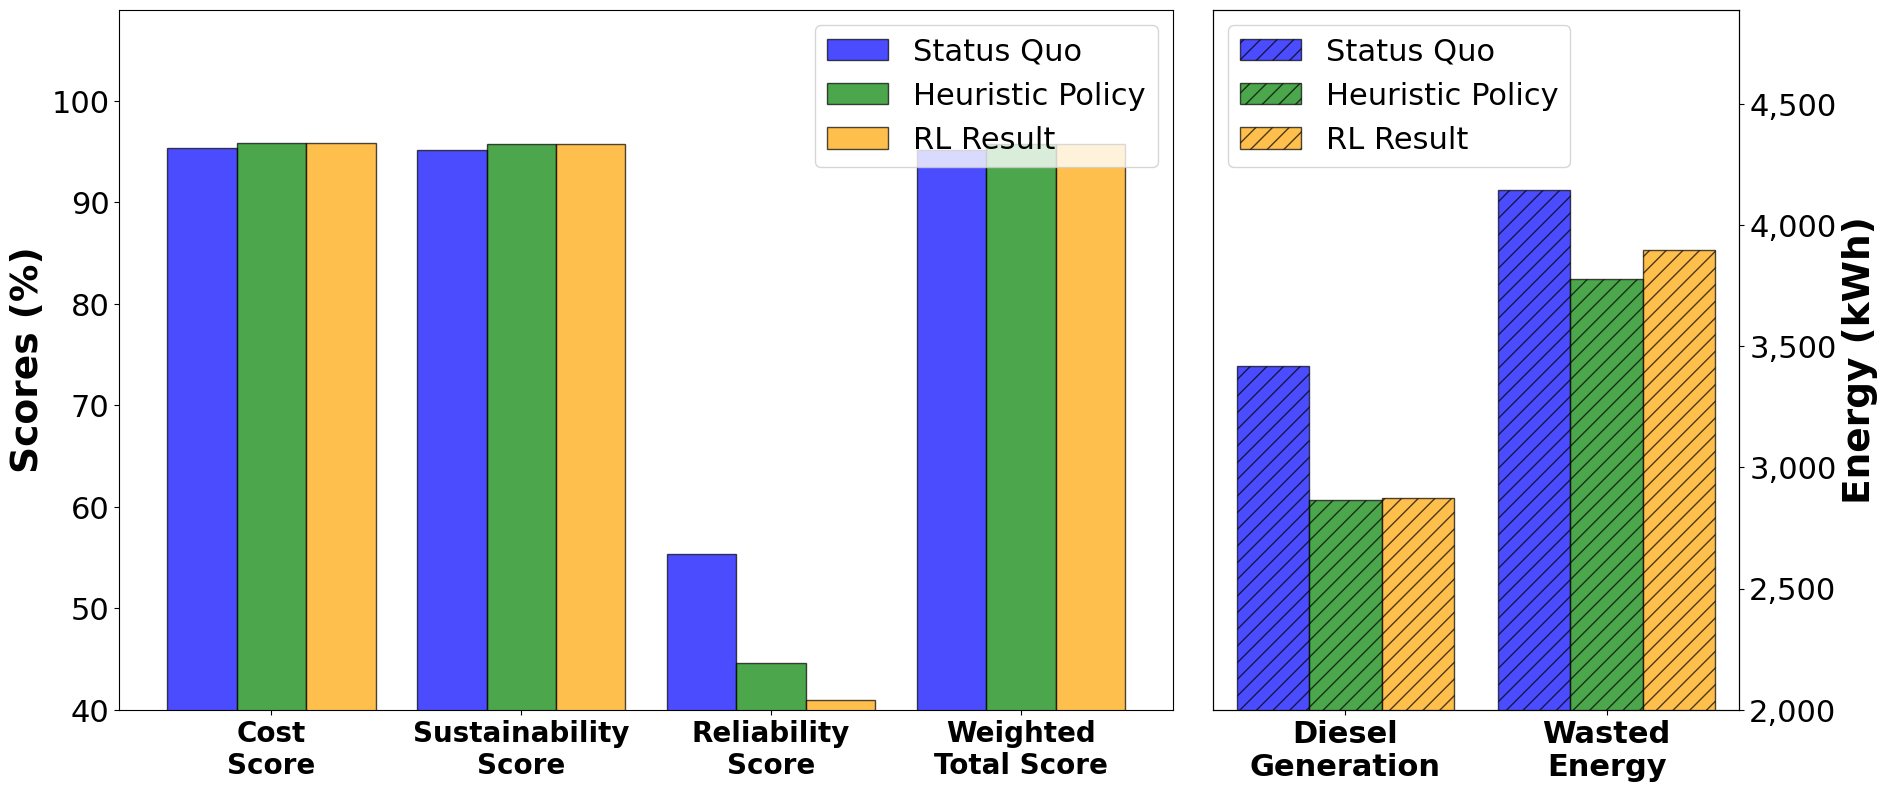

95.4
95.89
95.86

95.14
95.77
95.73

55.35
44.61
40.99

95.14
95.77
95.73


In [33]:
def format_yticks_comma(x, pos):
    return f'{int(x):,}'

#131313
C_RL = round(max(np.cumsum(Results_RL['Score_C']))*100/T,2)
S_RL = round(max(np.cumsum(Results_RL['Score_S']))*100/T,2)
R_RL = round(max(np.cumsum(Results_RL['Score_R']))*100/T,2)
T_RL = c_*C_RL + s_*S_RL + r_*R_RL
D_RL = max(np.cumsum(Results_RL['Diesel_Gen_kW']))/60
W_RL = max(np.cumsum(Results_RL['Excess_E_kW']))/60

#SQ 131313
C_SQ = round(max(np.cumsum(Results_SQ['Score_C']))*100/T,2)
S_SQ = round(max(np.cumsum(Results_SQ['Score_S']))*100/T,2)
R_SQ = round(max(np.cumsum(Results_SQ['Score_R']))*100/T,2)
T_SQ = c_*C_SQ + s_*S_SQ + r_*R_SQ
D_SQ = max(np.cumsum(Results_SQ['Diesel_Gen_kW']))/60
W_SQ = max(np.cumsum(Results_SQ['Excess_E_kW']))/60

#HU 131313
C_HU = round(max(np.cumsum(Results_HU['Score_C']))*100/T,2)
S_HU = round(max(np.cumsum(Results_HU['Score_S']))*100/T,2)
R_HU = round(max(np.cumsum(Results_HU['Score_R']))*100/T,2)
T_HU = c_*C_HU + s_*S_HU + r_*R_HU
D_HU = max(np.cumsum(Results_HU['Diesel_Gen_kW']))/60
W_HU = max(np.cumsum(Results_HU['Excess_E_kW']))/60

# Categories and values
categories = ['Cost\nScore', 'Sustainability\nScore', 'Reliability\nScore', 'Weighted\nTotal Score', 'Diesel\nGeneration', 'Wasted\nEnergy']
RL_values = [C_RL, S_RL, R_RL, T_RL, D_RL, W_RL]
SQ_values = [C_SQ, S_SQ, R_SQ, T_SQ, D_SQ, W_SQ]
HU_values = [C_HU, S_HU, R_HU, T_HU, D_HU, W_HU]

# Separate the categories for the left and right y-axes
left_categories = categories[:4]
right_categories = categories[4:]

# Position of the bars on the x-axis with increased spacing between groups
x = np.arange(len(categories)) * 0.9  # Adjust spacing between groups
width = 0.25  # Bar width

# Create a figure with two subplots
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(1, 2, width_ratios=[2, 1], wspace=0.05)

# Left subplot (for first four categories)
ax1 = fig.add_subplot(gs[0])

# Plotting Status Quo, Heuristic Policy, and RL values for the left y-axis categories
bars1 = ax1.bar(x[:4] - width, SQ_values[:4], width, label='Status Quo', color='blue', edgecolor='black', alpha=0.7)
bars2 = ax1.bar(x[:4], HU_values[:4], width, label='Heuristic Policy', color='green', edgecolor='black', alpha=0.7)
bars3 = ax1.bar(x[:4] + width, RL_values[:4], width, label='RL Result', color='orange', edgecolor='black', alpha=0.7)

# Setting the labels and title for the left y-axis
ax1.set_ylabel('Scores (%)', fontsize=27, fontweight='bold')
ax1.set_xticks(x[:4])
ax1.set_xticklabels(left_categories, fontsize=20, fontweight='bold')
ax1.tick_params(axis='y', labelsize=22)
ax1.set_ylim(40, 109)
ax1.yaxis.set_major_formatter(FuncFormatter(format_yticks_comma))

# Adding legend to the left subplot
handles1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(handles1, labels1, loc='upper right', fontsize=22)

# Right subplot (for last two categories)
ax2 = fig.add_subplot(gs[1])

# Plotting Status Quo, Heuristic Policy, and RL values for the right y-axis categories
bars4 = ax2.bar(x[4:] - width, SQ_values[4:], width, label='Status Quo', color='blue', edgecolor='black', alpha=0.7, hatch='//')
bars5 = ax2.bar(x[4:], HU_values[4:], width, label='Heuristic Policy', color='green', edgecolor='black', alpha=0.7, hatch='//')
bars6 = ax2.bar(x[4:] + width, RL_values[4:], width, label='RL Result', color='orange', edgecolor='black', alpha=0.7, hatch='//')

# Create a secondary y-axis for Diesel Generation and Wasted Energy
ax3 = ax2.twinx()

# Setting the labels and limits for the right y-axis
ax2.set_ylim(2000, 4890)
ax3.set_ylabel('Energy (kWh)', fontsize=27, fontweight='bold')
ax3.tick_params(axis='y', labelsize=22)
ax3.set_ylim(2000, 4890)
ax3.yaxis.set_major_formatter(FuncFormatter(format_yticks_comma))

# Format x-ticks and labels
ax2.set_xticks(x[4:])
ax2.set_xticklabels(right_categories, fontsize=20, fontweight='bold')
ax2.tick_params(axis='x', labelsize=22)
ax2.set_yticks([])

# Adding legend to the right subplot
handles2, labels2 = ax2.get_legend_handles_labels()
ax3.legend(handles2, labels2, loc='upper left', fontsize=22)

# Adjust layout
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.2)

# Save the plot with the highest resolution
plt.savefig('Scores_Comparison_Fig4.png', dpi=300, bbox_inches='tight')
plt.show()

print(C_SQ)
print(C_HU)
print(C_RL)
print()
print(S_SQ)
print(S_HU)
print(S_RL)
print()
print(R_SQ)
print(R_HU)
print(R_RL)
print()
print(T_SQ)
print(T_HU)
print(T_RL)
